In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd

import itertools
import datetime
import time
import sys  
import re

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import tf_metrics as metrics

from soundings.preprocessing import dataloader as dl

from soundings.plotting import radiosonde_plotting, results
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'
PLOT_CMAP = 'RdYlBu_r'

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Fri Oct 23 21:24:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   36C    P8    13W / 260W |   1286MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

# Evaluation Functions

In [3]:
def parition(rap=None, raob=None, goes=None, rtma=None, 
             percentages=(0.8,0.2), shuffle=False):
    
    trainFraction, testFraction = percentages
    n = raob.shape[0]
    nTrain = round(trainFraction * n)
    nTest = round(testFraction * n)
    rowIndices = np.arange(n)
    if shuffle:
        np.random.shuffle(rowIndices)
        
    RAPtrain  = None
    RAPtest   = None
    RAOBtrain = None
    RAOBtest  = None
    GOEStrain = None
    GOEStest  = None
    RTMAtrain = None
    RTMAtest  = None
    
    if rap is not None:
        RAPtrain = rap[rowIndices[:nTrain], :]
        RAPtest  = rap[rowIndices[nTrain:nTrain+nTest], :]
        
    if raob is not None:
        RAOBtrain = raob[rowIndices[:nTrain], :]
        RAOBtest  = raob[rowIndices[nTrain:nTrain+nTest], :]
        
    if goes is not None:
        GOEStrain = goes[rowIndices[:nTrain], :]
        GOEStest  = goes[rowIndices[nTrain:nTrain+nTest], :]
        
    if rtma is not None:
        RTMAtrain = rtma[rowIndices[:nTrain], :]
        RTMAtest  = rtma[rowIndices[nTrain:nTrain+nTest], :]
    
    return (RAPtrain, RAOBtrain, GOEStrain, RTMAtrain,
            RAPtest, RAOBtest, GOEStest, RTMAtest)

# Data Loader

In [4]:
raob, rap, goes, rtma, sonde_files = dl.load_preprocessed_samples(processed_vol, shuffle=True)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

total of 1283 samples!


FloatProgress(value=0.0, max=1283.0)

time: 33.208, avg: 0.026 seconds
(1283, 256, 4) (1283, 256, 4) (1283, 3, 3, 8) (1283, 3, 3, 3)


In [4]:
f = '/mnt/data1/stock/mlsoundings/preprocessed.npz'
# np.savez(f, raob=raob, rap=rap,
#          goes=goes, rtma=rtma, sonde_files=sonde_files)

container = np.load(f)

print(container.files)

raob = container['raob']
rap = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files']

print(raob.shape, rap.shape, goes.shape, rtma.shape)

['raob', 'rap', 'goes', 'rtma', 'sonde_files']
(35207, 256, 4) (35207, 256, 4) (35207, 3, 3, 8) (35207, 3, 3, 3)


In [5]:
nans = np.unique(np.argwhere(np.isnan(goes))[:,0])
nans

array([ 1267,  1271,  4925,  4929,  5912,  5916,  6340,  8812, 10431,
       13953, 13956, 14450, 14454, 15473, 15477, 16007, 16011, 16529,
       16533, 17042, 17564, 17567, 18627, 21784, 21788, 24377, 25875,
       27861, 27865, 28003, 28007, 28564, 28568, 29118, 29122, 31251,
       31255, 34896, 34900])

In [6]:
raob = np.delete(raob, nans, 0)
rap  = np.delete(rap, nans, 0)
goes = np.delete(goes, nans, 0)
rtma = np.delete(rtma, nans, 0)
sonde_files = np.delete(np.array(sonde_files), nans, 0)

In [7]:
ml.rmse(rap[:,:,dl.DEWPOINT], raob[:,:,dl.DEWPOINT]), ml.rmse(rap[:,:,dl.TEMPERATURE], raob[:,:,dl.TEMPERATURE])

(5.51685575001106, 1.1791526028903745)

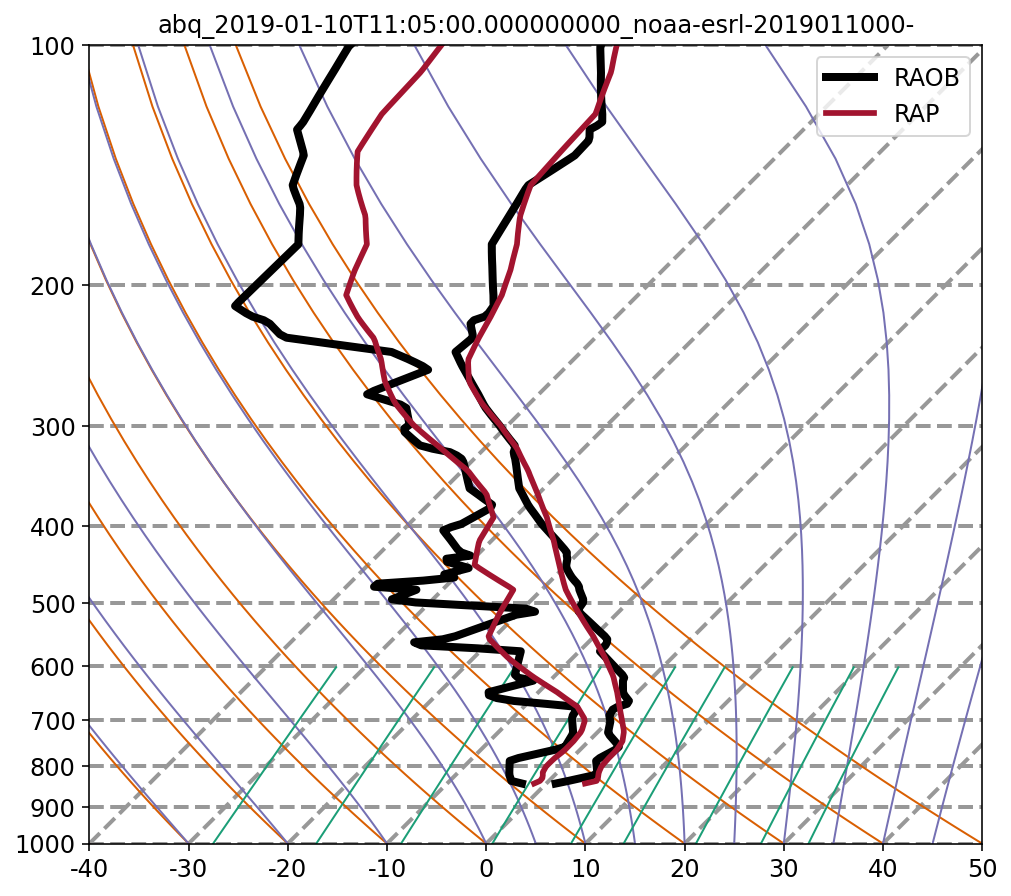

In [8]:
index = 3
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = rap[index,:,dl.PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = rap[index,:,dl.TEMPERATURE]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = raob[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = rap[index,:,dl.DEWPOINT]

title = sonde_files[index].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");

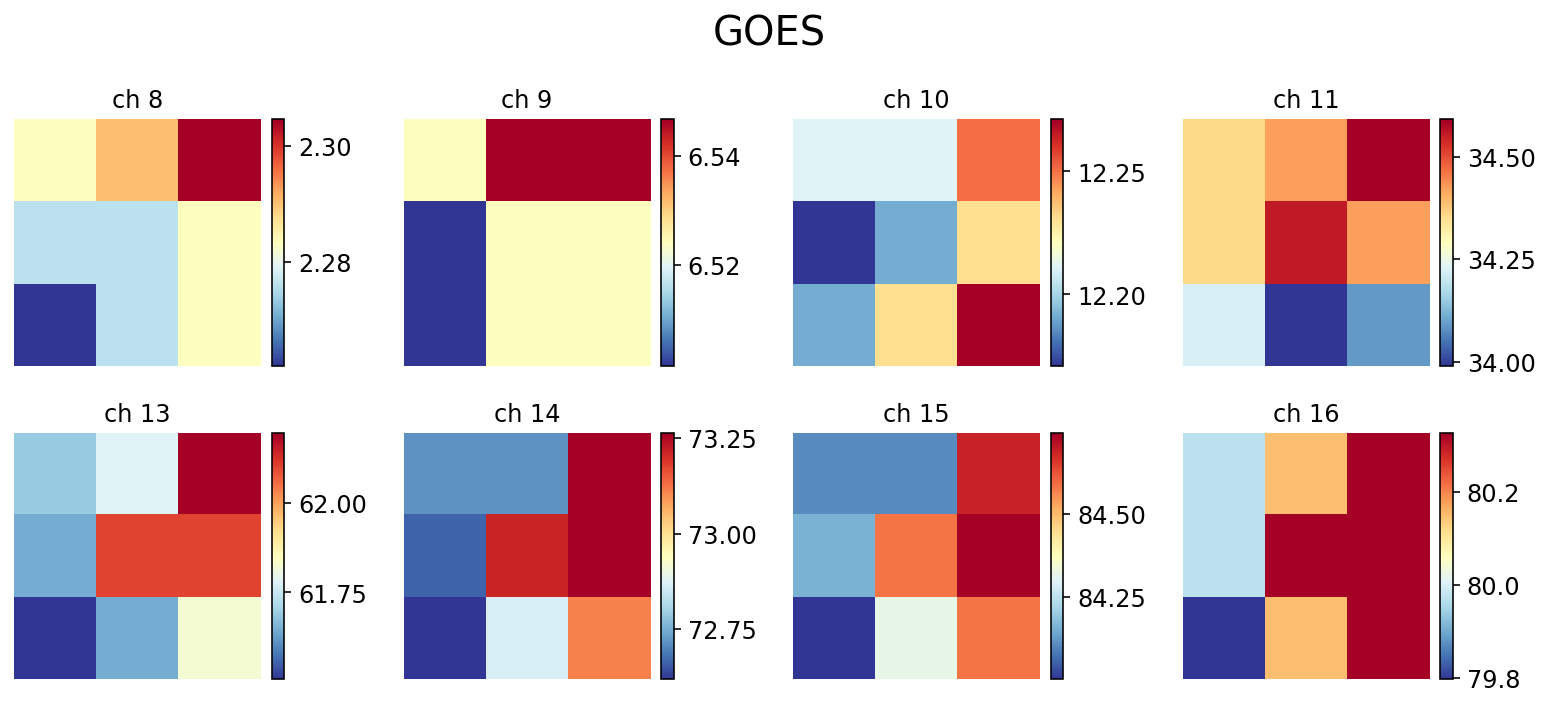

In [9]:
bands = np.array([8, 9, 10, 11, 13, 14, 15, 16])

# vmin = goes[index,:,:,:].min()
# vmax = goes[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(11,5))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    c = axs[r, i % 4].imshow(goes[index,:,:,i], cmap=PLOT_CMAP) # vmin=vmin, vmax=vmax,
    cbar = fig.colorbar(c, ax=axs[r, i % 4], fraction=0.046, pad=0.04)
    cbar.ax.locator_params(nbins=3)
    axs[r, i % 4].set_title(f'ch {str(bands[i])}')
plt.suptitle('GOES', fontsize=20)
fig.tight_layout()

# RAP + GOES

## Predicting Surface Values

In [29]:
_, RAOBtrain, GOEStrain, _, _, RAOBtest, GOEStest, _ = parition(rap=rap, raob=raob, goes=goes, shuffle=True)

GOEStrain = GOEStrain[:, 1, 1, :].reshape(GOEStrain.shape[0], -1)
GOEStest = GOEStest[:, 1, 1, :].reshape(GOEStest.shape[0], -1)

RAOBtrain = RAOBtrain[:, 0, dl.TEMPERATURE].reshape(-1,1)
RAOBtest = RAOBtest[:, 0, dl.TEMPERATURE].reshape(-1,1)

RAOBtrain.shape, GOEStrain.shape, RAOBtest.shape, GOEStest.shape

((22410, 1), (22410, 8), (5603, 1), (5603, 8))

In [30]:
nnet = nn.NeuralNetwork(GOEStrain.shape[1], [10]*4, RAOBtrain.shape[1], activation='relu')
nnet.train(GOEStrain, RAOBtrain, 100, 32, method='adam',
           verbose=True, learning_rate=0.001, validation=(GOEStest, RAOBtest))

epoch: 0, rmse 8.61414, val_rmse 7.49926
epoch: 20, rmse 5.60180, val_rmse 6.51957
epoch: 40, rmse 5.53171, val_rmse 5.60997
epoch: 60, rmse 5.41549, val_rmse 5.67860
epoch: 80, rmse 5.38984, val_rmse 5.38002
epoch: 99, rmse 5.32983, val_rmse 5.24489
finished!


NeuralNetwork(8, [10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 1)
  Final objective value is 0.22447 in 186.5166 seconds.

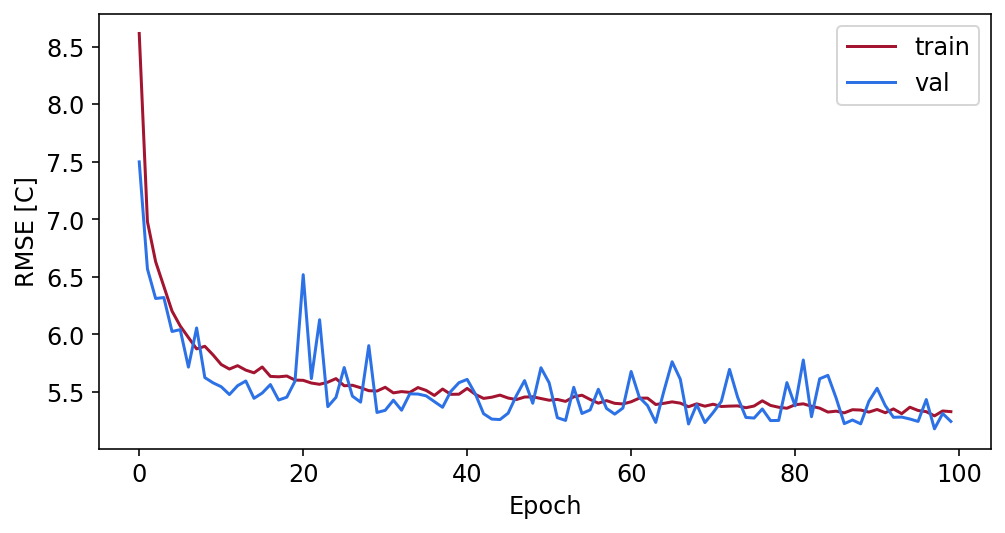

In [31]:
results.plot_loss(nnet)

## Predicting Entire Profile

In [11]:
RAPtrain, RAOBtrain, GOEStrain, _, RAPtest, RAOBtest, GOEStest, _ = parition(rap=rap, raob=raob, goes=goes)

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, dl.TEMPERATURE]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, dl.TEMPERATURE]

# GOEStrain = GOEStrain[:, :, :, 0:1]
# GOEStest = GOEStest[:, :, :, 0:1]

RAPtrain.shape, RAOBtrain.shape, GOEStrain.shape, RAPtest.shape, RAOBtest.shape, GOEStest.shape

((28134, 256, 3),
 (28134, 256),
 (28134, 3, 3, 8),
 (7034, 256, 3),
 (7034, 256),
 (7034, 3, 3, 8))

In [33]:
goes_hiddens = []
n_units_in_conv = [32, 32, 32]

nnet = nn.MultiNeuralNetwork(GOEStrain.shape[1:], RAPtrain.shape[1:],
                             goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                             RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', seed=1234)

nnet.train(GOEStrain, RAPtrain, RAOBtrain, 100, 32, method='adam',
                     validation=(GOEStest, RAPtest, RAOBtest), verbose=True, learning_rate=0.0001)

epoch: 0, rmse 2.37167, val_rmse 1.42609
epoch: 5, rmse 1.18565, val_rmse 1.07108
epoch: 10, rmse 1.15173, val_rmse 1.05145
epoch: 15, rmse 1.13723, val_rmse 1.05264
epoch: 20, rmse 1.13609, val_rmse 1.03727
epoch: 25, rmse 1.12575, val_rmse 1.02709
epoch: 30, rmse 1.12206, val_rmse 1.02963


MultiNeuralNetwork(256)
  Final objective value is 0.03408 in 85.6701 seconds.

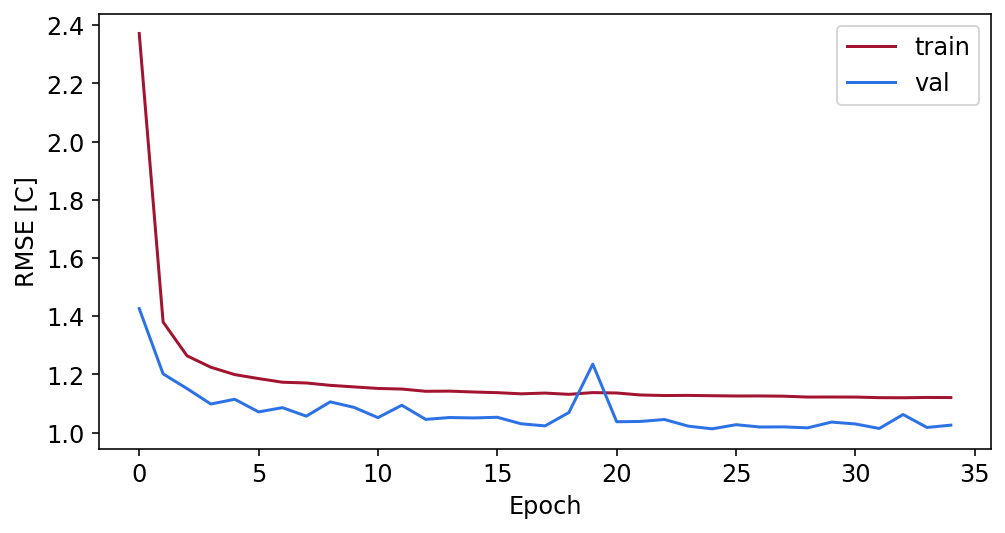

In [34]:
results.plot_loss(nnet)

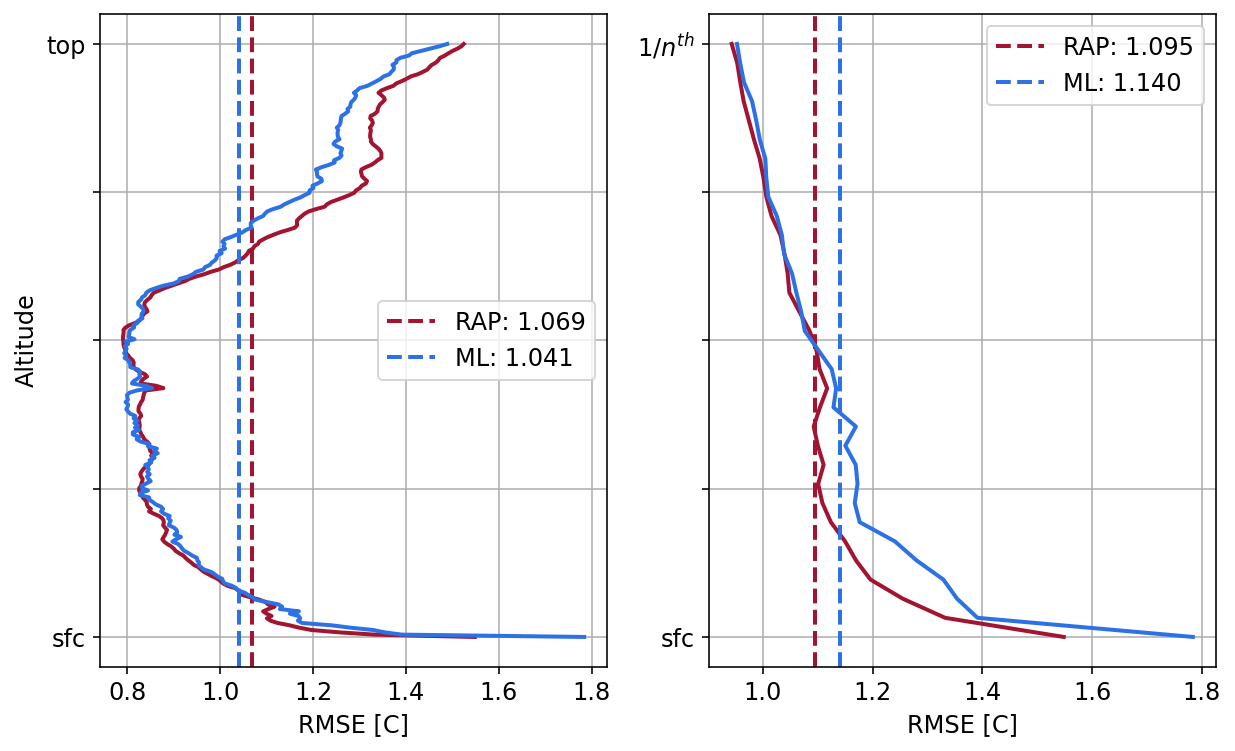

In [35]:
results.plot_altitude_rmse_verticle(nnet, {'im': GOEStest, 'rap': RAPtest},
                            RAOBtest, RAPtest[:,:,dl.TEMPERATURE], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

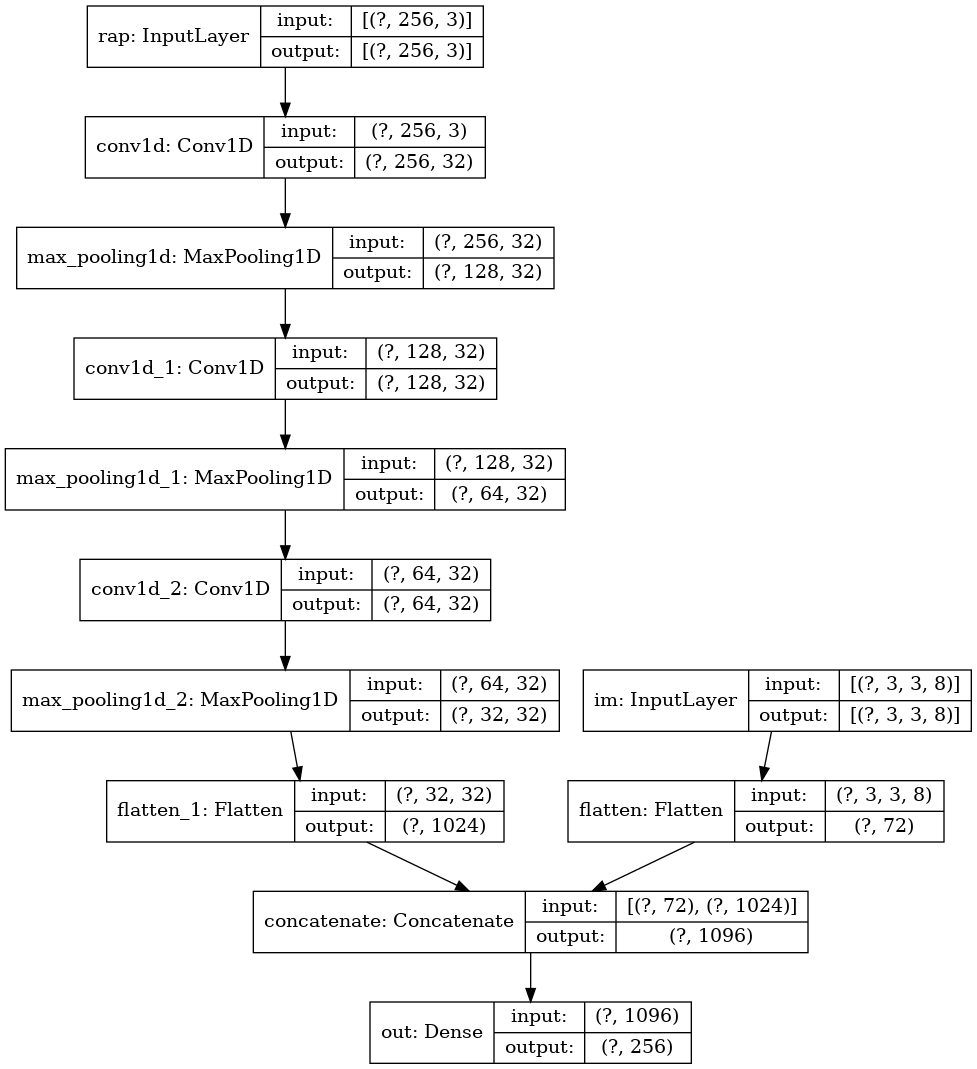

In [36]:
tf.keras.utils.plot_model(nnet.model, show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

In [11]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

goes_hiddens_list = [[]] + [[nu] * nl for nu in [4, 8, 16] for nl in range(1, 4)]
n_units_in_conv_layers = [[nu] * nl for nu in [4, 8, 16] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(goes_hiddens_list, n_units_in_conv_layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for goes_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(GOEStrain.shape[1:], RAPtrain.shape[1:],
                                 goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                 RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', seed=1234)
    nnet.train(GOEStrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
               verbose=False, learning_rate=0.001)

    Y = nnet.use({'im': GOEStrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': GOEStest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet

    f.value += 1

FloatProgress(value=0.0, max=90.0)

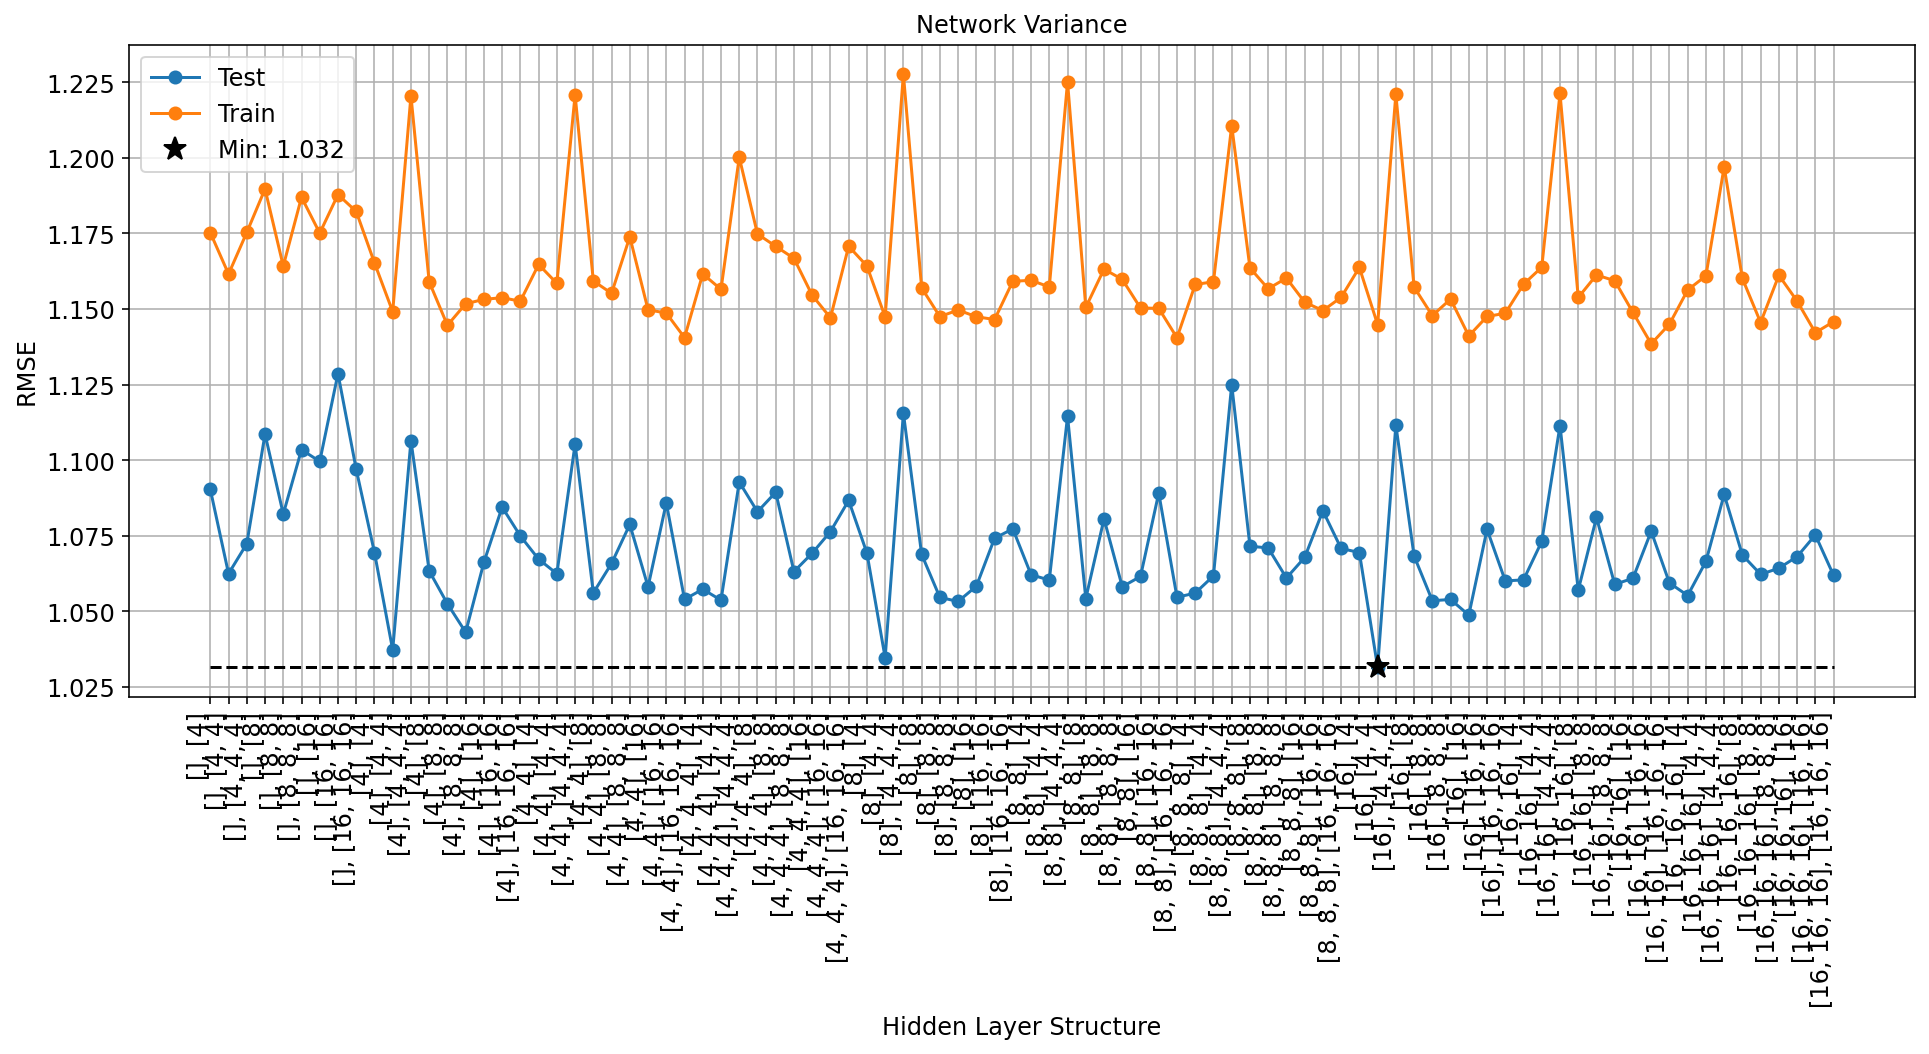

In [12]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

In [12]:
nnet = nn.MultiNeuralNetwork(GOEStrain.shape[1:], RAPtrain.shape[1:],
                             [16], [128, 128], [(10, 1)]*2, 
                             RAOBtrain.shape[1], im_activation='tanh',
                             rap_activation='tanh')

nnet.train(GOEStrain, RAPtrain, RAOBtrain, 100, 64, method='adam',
           validation=(GOEStest, RAPtest, RAOBtest), verbose=True, learning_rate=0.0001)

epoch: 0, rmse 1.64780, val_rmse 1.18464
epoch: 20, rmse 1.13964, val_rmse 1.02150


MultiNeuralNetwork(256)
  Final objective value is 0.03512 in 49.2025 seconds.

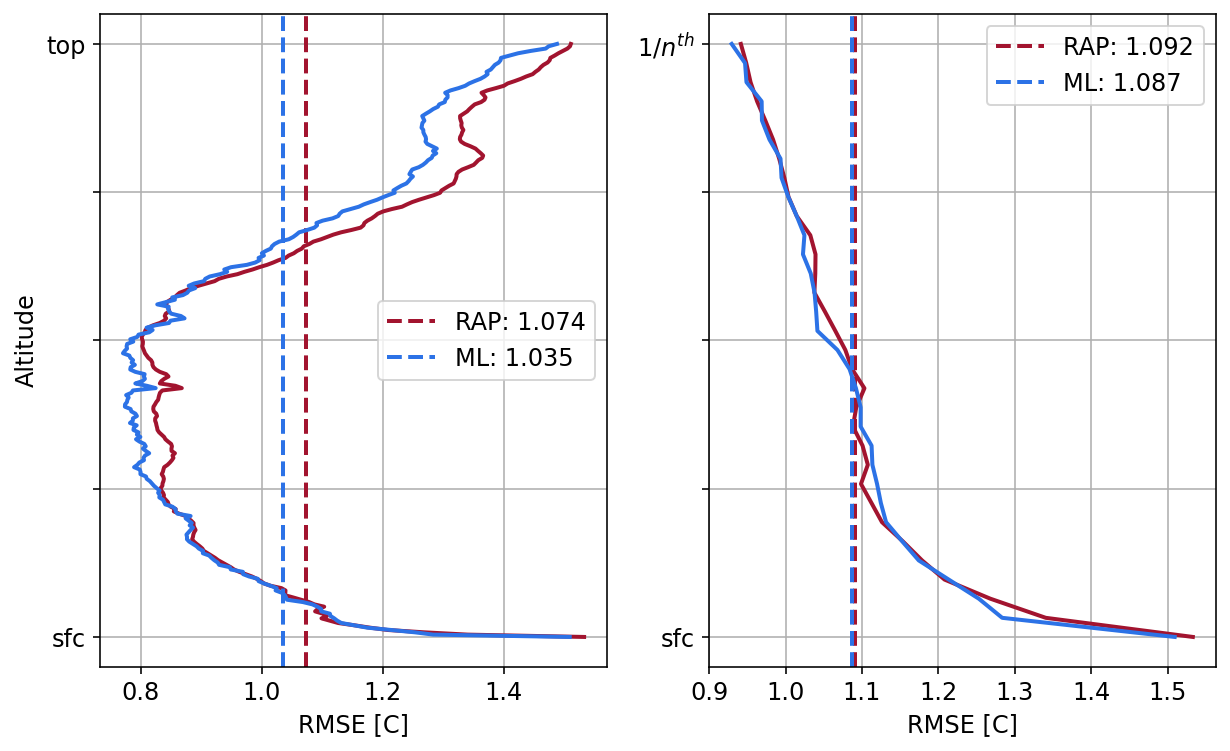

In [15]:
results.plot_altitude_rmse_verticle(nnet, {'im': GOEStest, 'rap': RAPtest},
                            RAOBtest, RAPtest[:,:,dl.TEMPERATURE], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

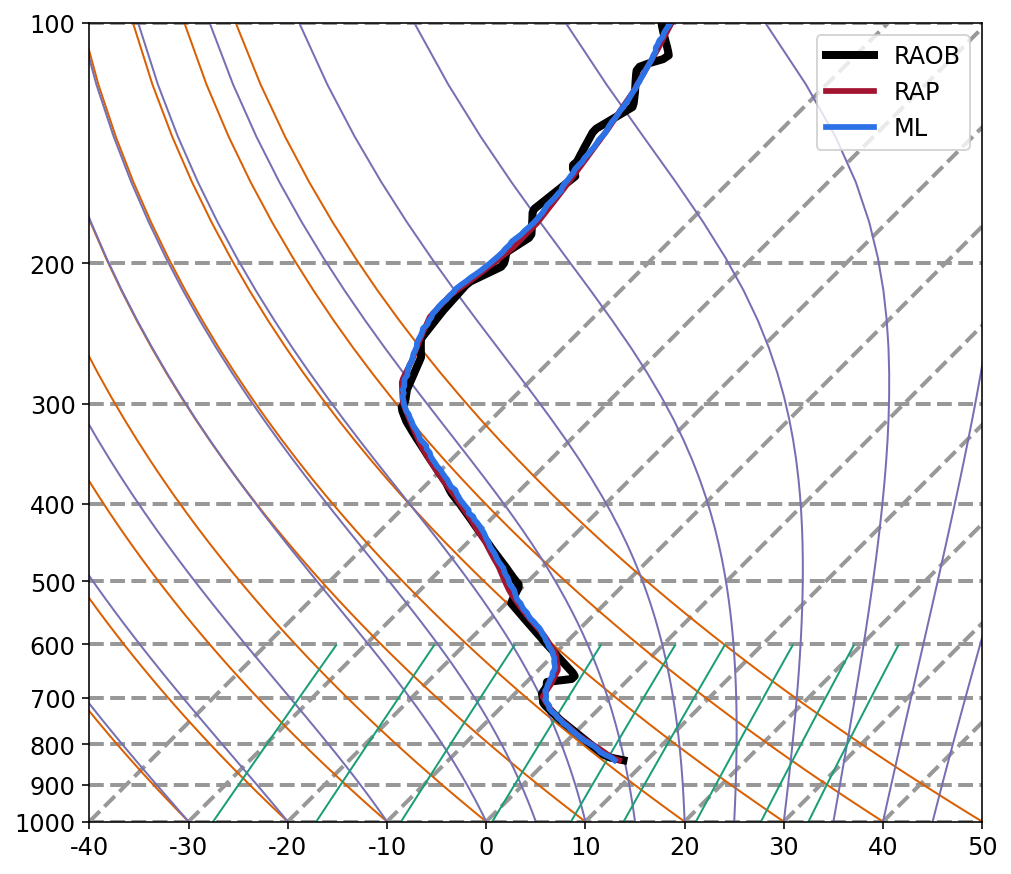

In [16]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use({'im':GOEStrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

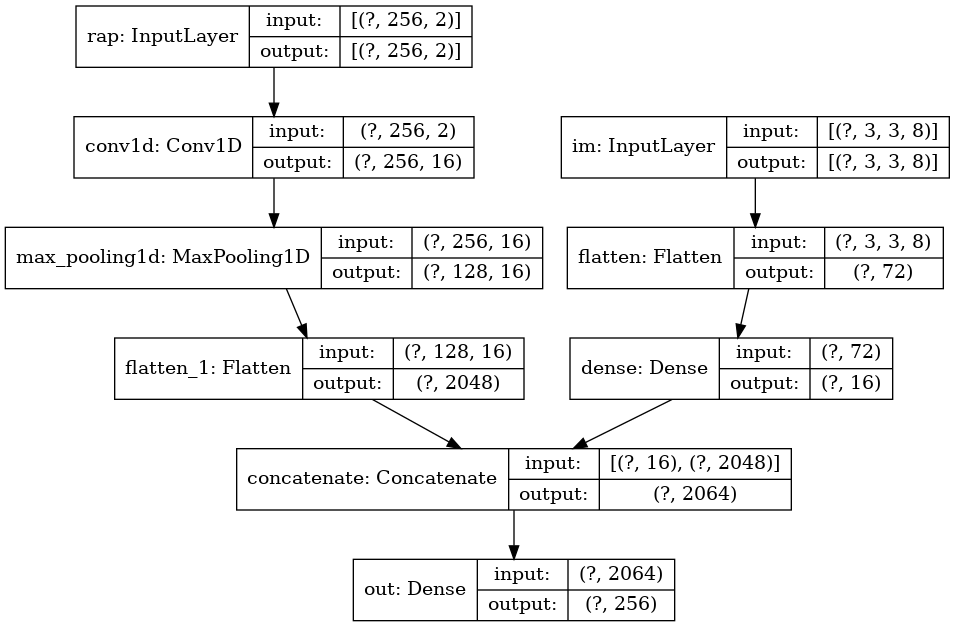

In [97]:
tf.keras.utils.plot_model(best_nnet.model, '/home/stock/research/media/multi_input_and_output_model.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

In [98]:
bands_indicies = np.arange(len(bands))
combinations = []
for length in [0, 1, 2]:
    combinations += list(itertools.combinations(bands_indicies, length+1))
len(combinations)

92

In [99]:
all_trials = []
trials = 10

f = FloatProgress(min=0, max=len(combinations) * trials)
display(f)

for c in combinations:

    IMtrain = GOEStrain[:,:,:, c]
    IMtest = GOEStest[:,:,:, c]

    trial = []

    for t in range(trials):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [16], [16], [(10, 1)], 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
                   verbose=False, learning_rate=0.001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        f.value += 1
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

FloatProgress(value=0.0, max=920.0)

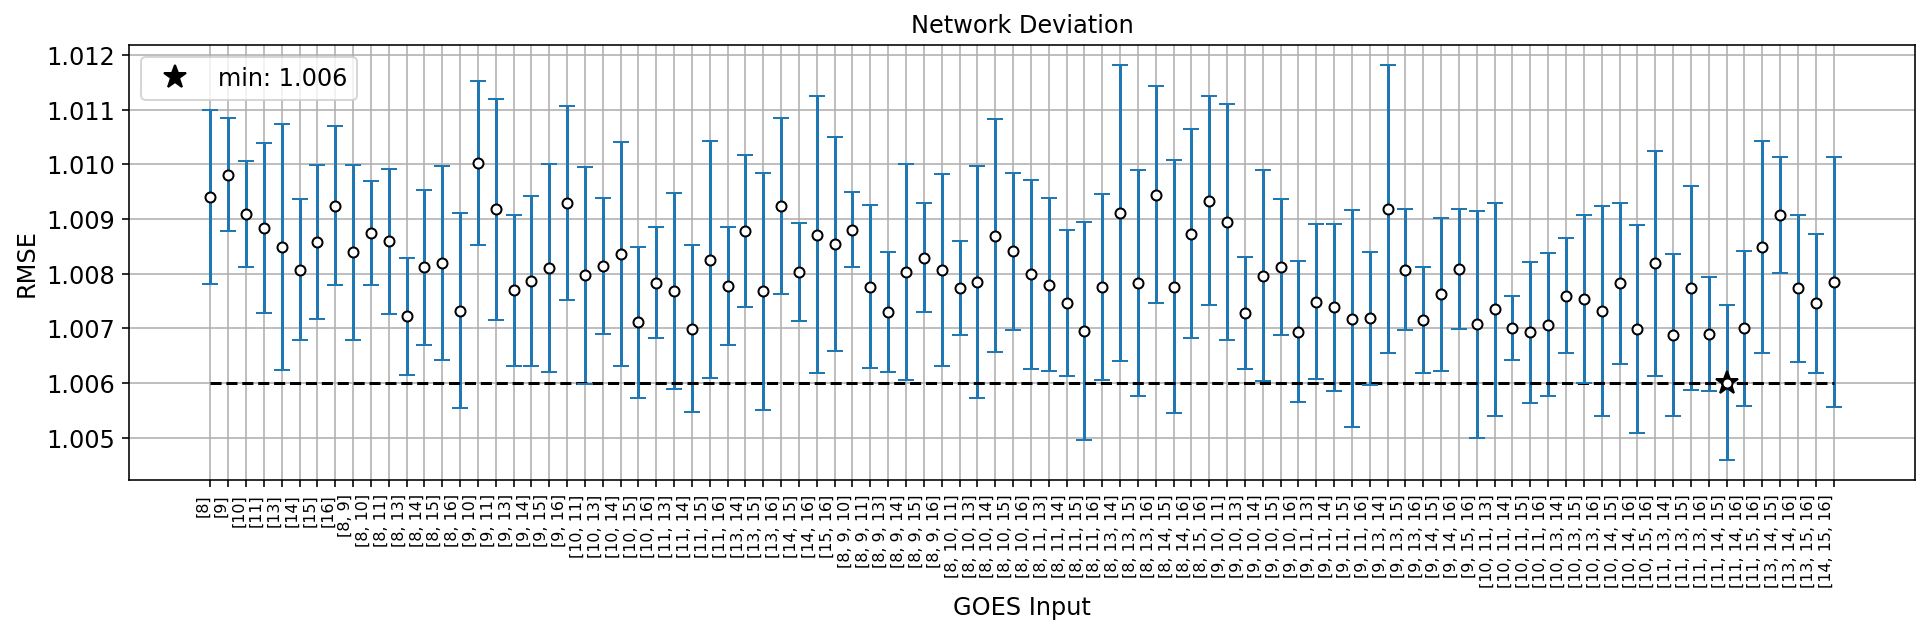

In [100]:
labels = [bands[list(c)].tolist() for c in combinations]

fig, ax = plt.subplots(1, figsize=(16, 4))

means = all_trials.mean(axis=1)

ax.errorbar(np.arange(len(combinations)), means, yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, horizontalalignment='right', size=8)

top_index = np.argmin(means)
top = means[top_index]

ax.hlines(top, 0, len(means) - 1, linestyle='dashed', color='black')
ax.plot(top_index, top, 'k*', markersize=12, label=f'min: {top:.3f}')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('GOES Input'); ax.set_ylabel('RMSE');
ax.legend(loc=2);

In [176]:
bands

array([ 8,  9, 10, 11, 13, 14, 15, 16])

In [177]:
IMtrain = GOEStrain[:,:,:, (0,)]
IMtest = GOEStest[:,:,:, (0,)]

In [180]:
nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                             [8, 8, 8], [16], [(10, 1)], 
                              RAOBtrain.shape[1], im_activation='tanh',
                              rap_activation='tanh')

nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
                   verbose=False, learning_rate=0.001)

MultiNeuralNetwork(256)
  Final objective value is 0.04937 in 2.6866 seconds.

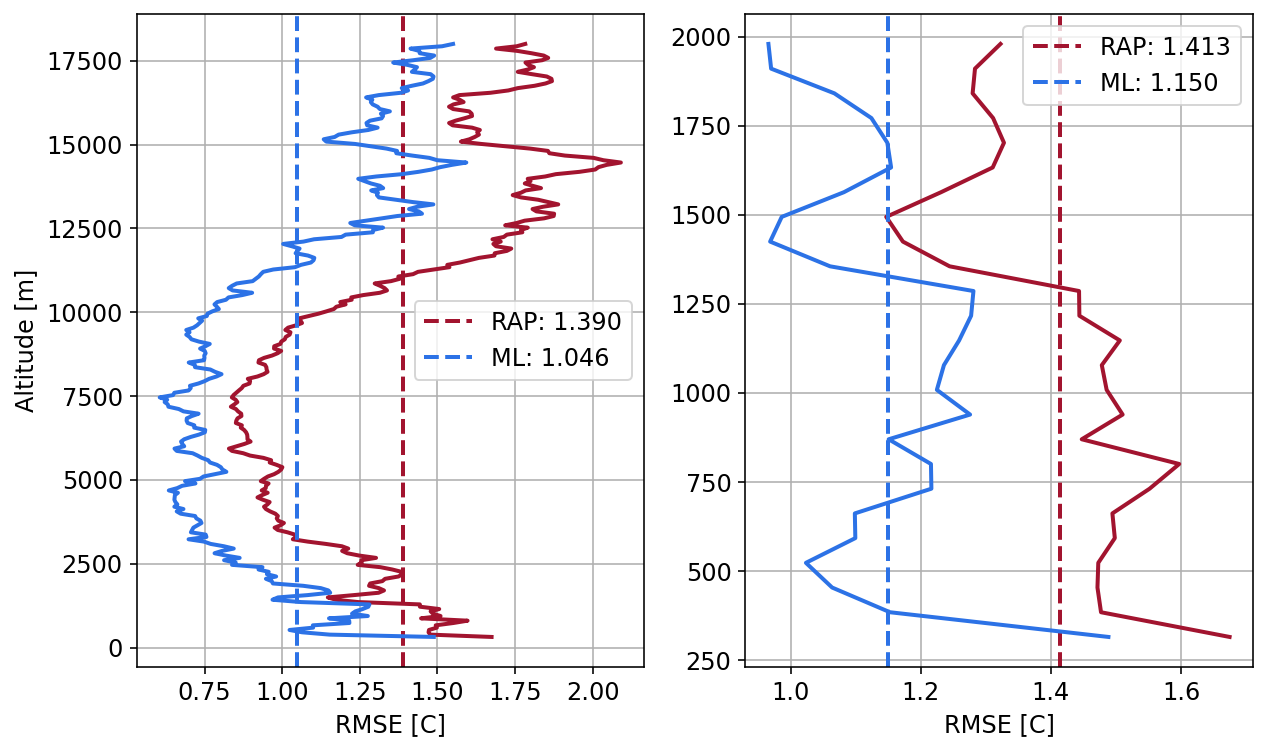

In [183]:
plot_altitude_rmse_verticle(nnet, {'im': IMtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,TEMPERATURE], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

### Moisture

In [234]:
RAPtrain, RAOBtrain, GOEStrain, _, RAPtest, RAOBtest, GOEStest, _ = parition(rap=rap, raob=raob, goes=goes)

input_dims = [PRESSURE, DEWPOINT]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, DEWPOINT]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, DEWPOINT]

# GOEStrain = GOEStrain[:, :, :, 0:1]
# GOEStest = GOEStest[:, :, :, 0:1]

RAPtrain.shape, RAOBtrain.shape, GOEStrain.shape, RAPtest.shape, RAOBtest.shape, GOEStest.shape

((587, 256, 2),
 (587, 256),
 (587, 3, 3, 8),
 (147, 256, 2),
 (147, 256),
 (147, 3, 3, 8))

In [235]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

goes_hiddens_list = [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 4)]
n_units_in_conv_layers = [[nu] * nl for nu in [4, 8, 16] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(goes_hiddens_list, n_units_in_conv_layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for goes_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(GOEStrain.shape[1:], RAPtrain.shape[1:],
                                 goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                 RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', seed=1234)
    nnet.train(GOEStrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
               verbose=False, learning_rate=0.001)

    Y = nnet.use({'im': GOEStrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': GOEStest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet

    f.value += 1

FloatProgress(value=0.0, max=81.0)

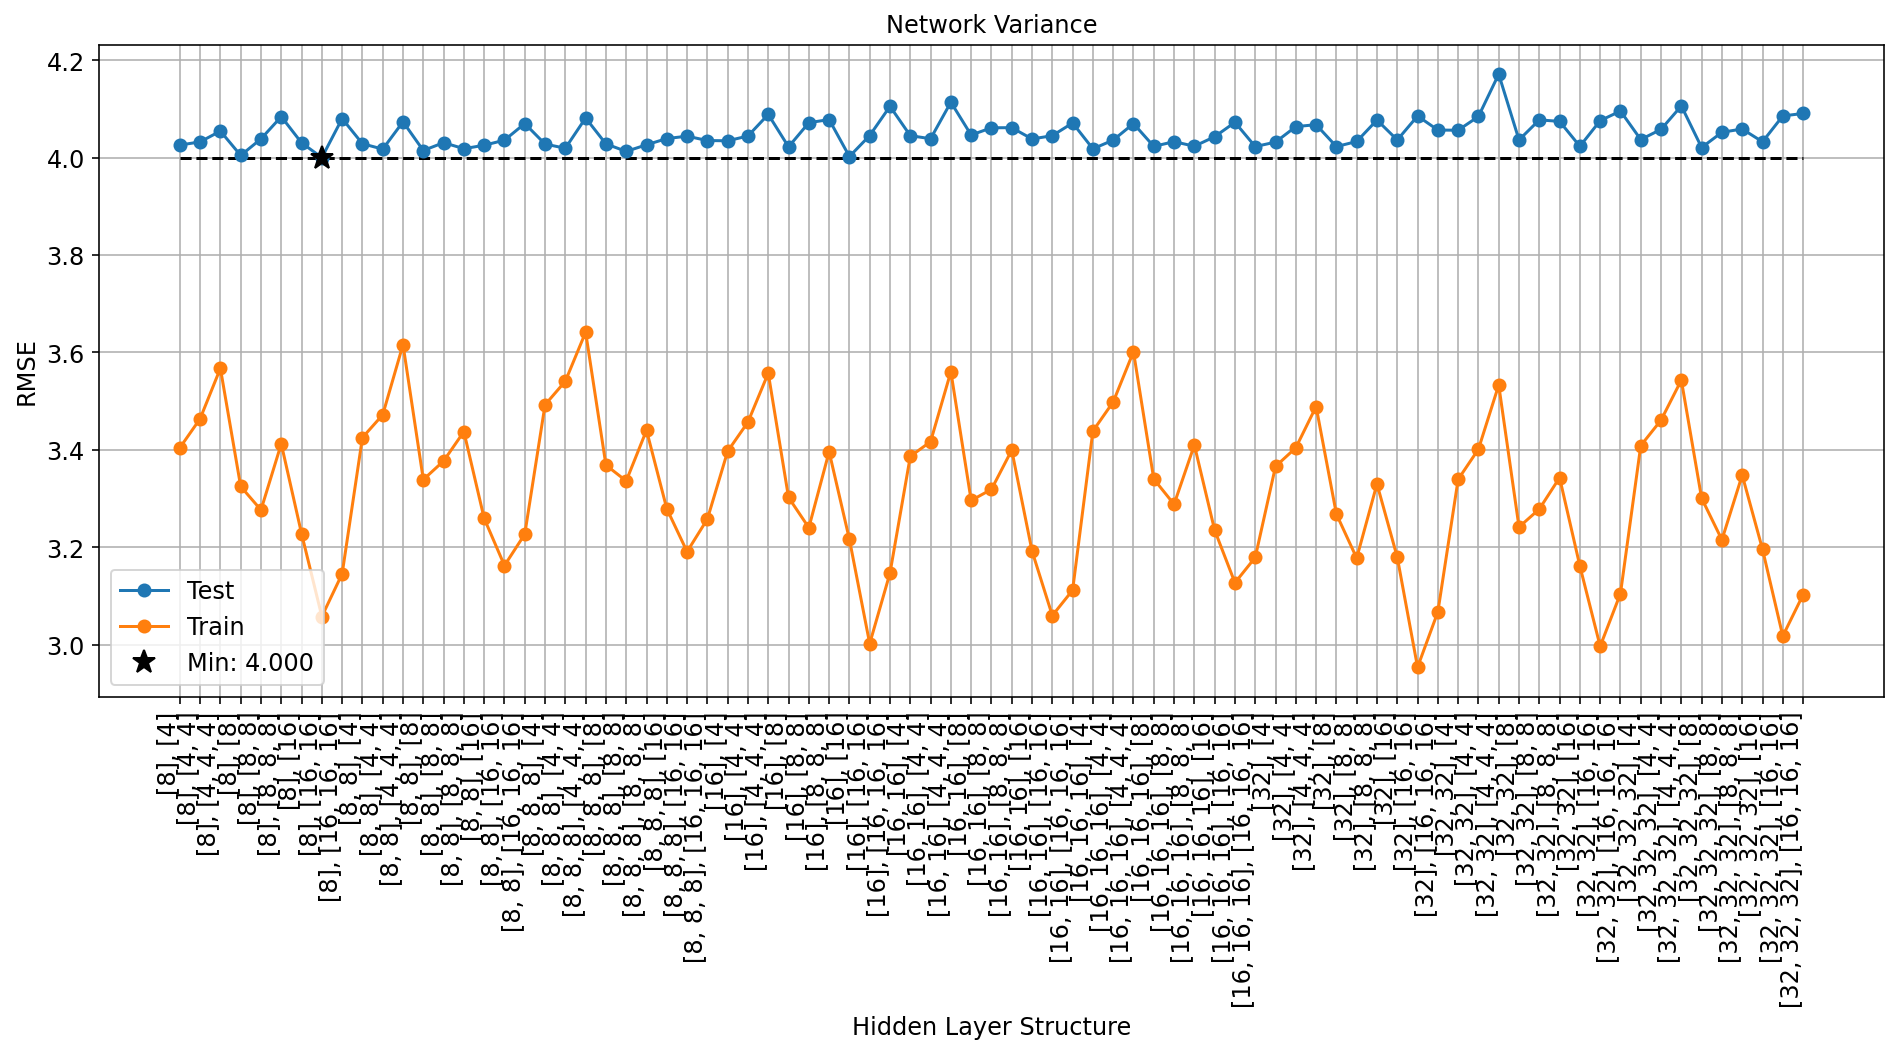

In [236]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

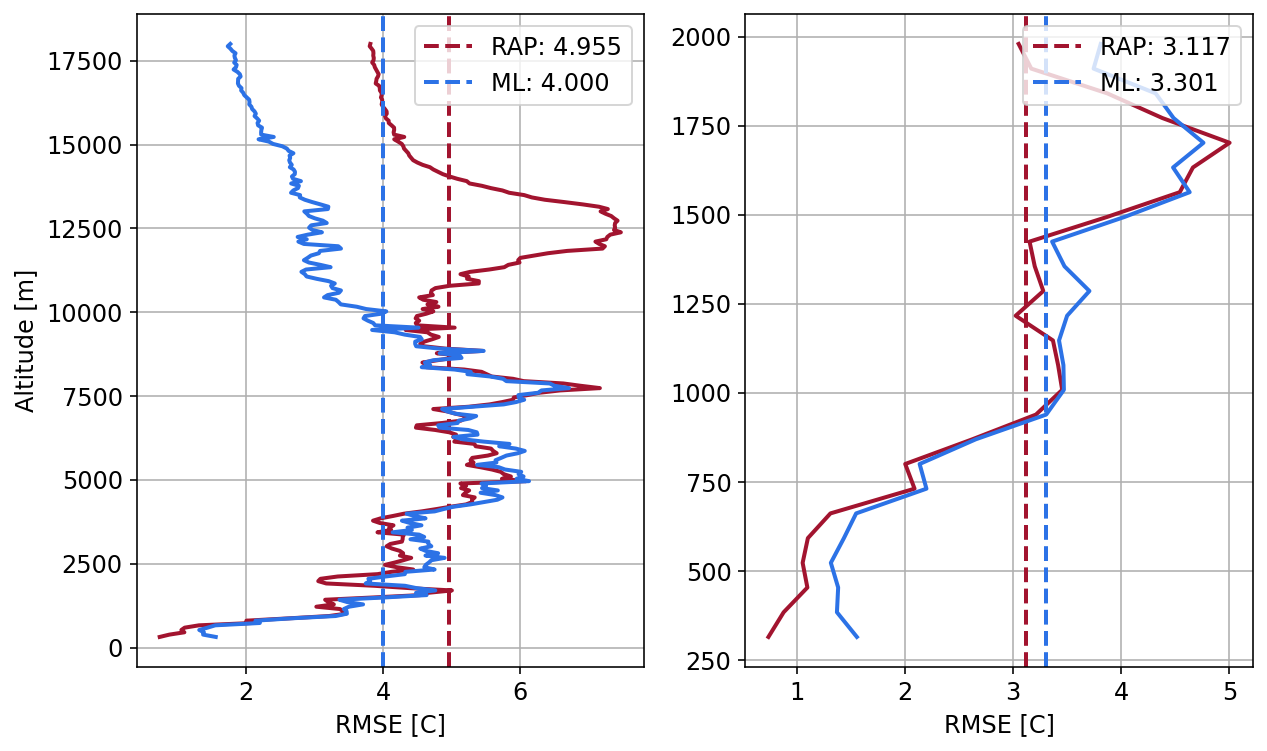

In [239]:
plot_altitude_rmse_verticle(best_nnet, {'im': GOEStest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

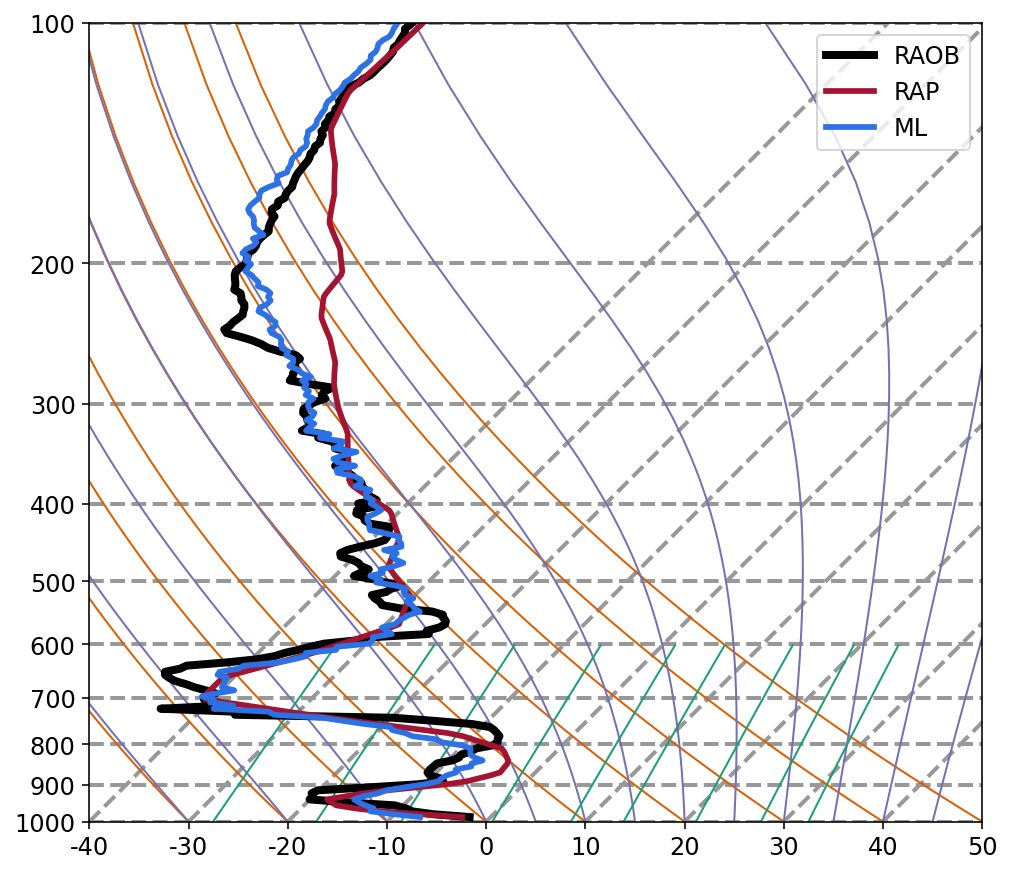

In [240]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':GOEStrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [241]:
interm = tf.keras.Model(best_nnet.model.inputs,best_nnet.model.get_layer('concatenate').output)
def iterm_predict(goes, rap):
    goes = best_nnet._standardizeIM(goes)
    rap  = best_nnet._standardizeRAP(rap)
    return interm.predict({'imgoes': goes, 'rap': rap})

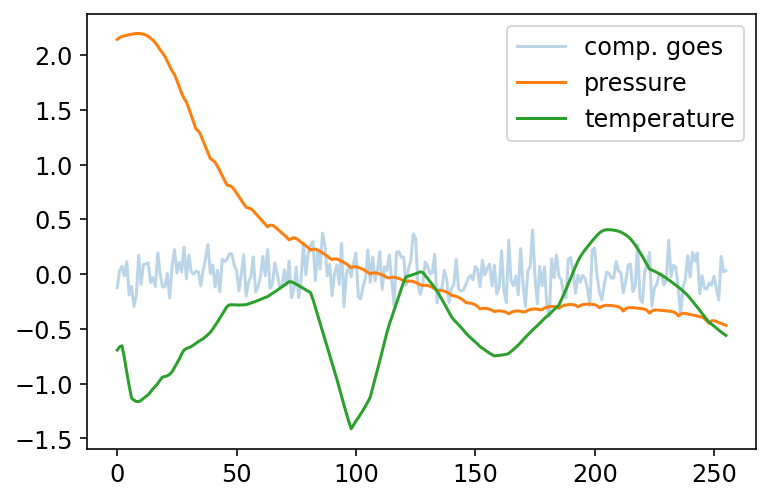

In [242]:
i = 0
Y = iterm_predict(GOEStrain[i:i+1], RAPtrain[i:i+1])

plt.plot(Y[0,:,2], alpha=0.3, label='comp. goes')
plt.plot(Y[0,:,0], label='pressure')
plt.plot(Y[0,:,1], label='temperature')

plt.legend();

In [243]:
bands_indicies = np.arange(len(bands))
combinations = []
for length in [0, 1, 2]:
    combinations += list(itertools.combinations(bands_indicies, length+1))
len(combinations)

92

In [244]:
all_trials = []
trials = 10

f = FloatProgress(min=0, max=len(combinations) * trials)
display(f)

for c in combinations:

    IMtrain = GOEStrain[:,:,:, c]
    IMtest = GOEStest[:,:,:, c]

    trial = []

    for t in range(trials):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [8], [16, 16], [(10, 1)], 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 25, 32, method='adam',
                   verbose=False, learning_rate=0.001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        f.value += 1
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

FloatProgress(value=0.0, max=920.0)

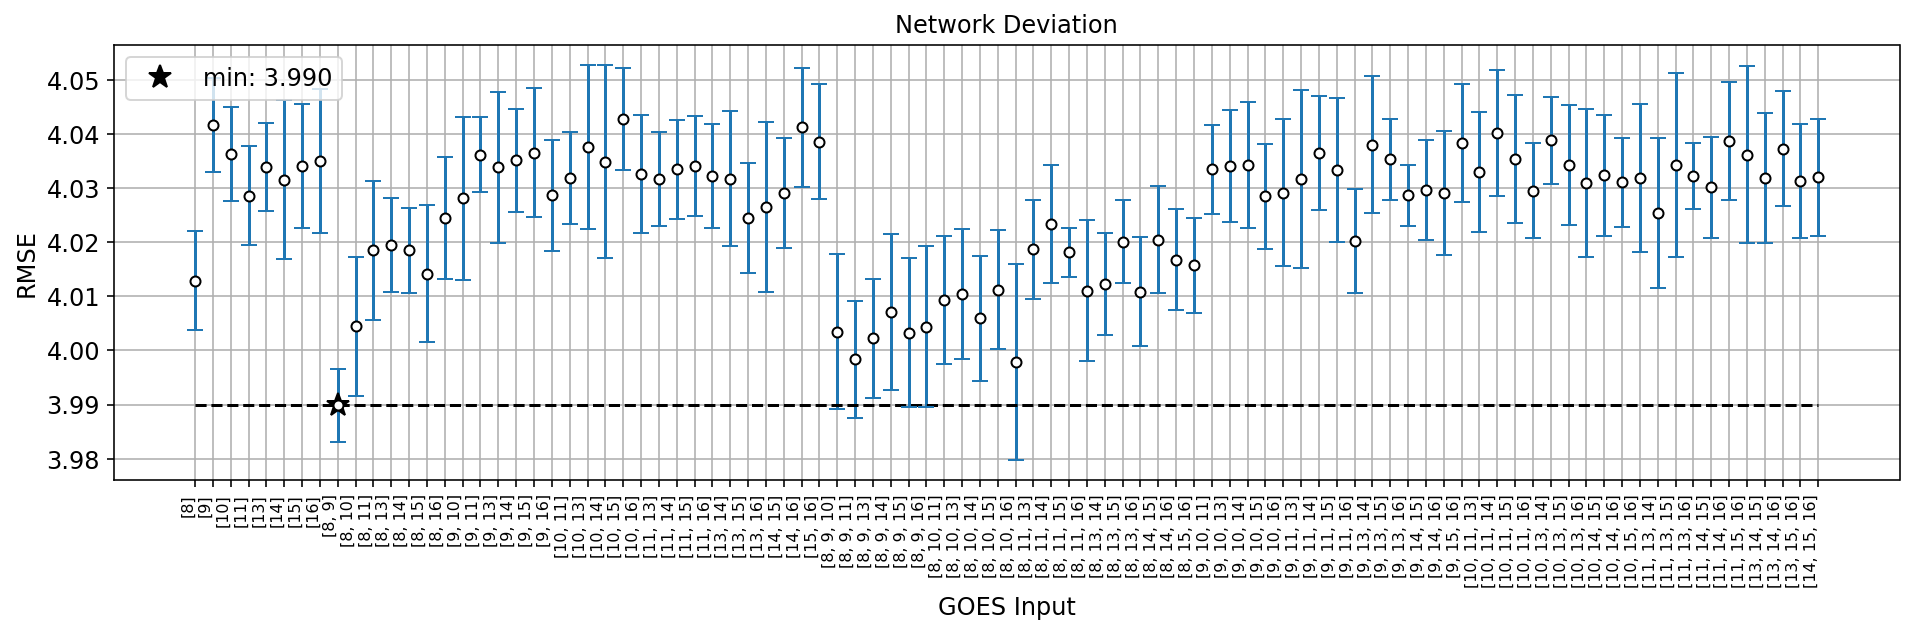

In [248]:
labels = [bands[list(c)].tolist() for c in combinations]

fig, ax = plt.subplots(1, figsize=(16, 4))

means = all_trials.mean(axis=1)

ax.errorbar(np.arange(len(combinations)), means, yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, horizontalalignment='right', size=8)

top_index = np.argmin(means)
top = means[top_index]

ax.hlines(top, 0, len(means) - 1, linestyle='dashed', color='black')
ax.plot(top_index, top, 'k*', markersize=12, label=f'min: {top:.3f}')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('GOES Input'); ax.set_ylabel('RMSE');
ax.legend(loc=2);

In [246]:
bands

array([ 8,  9, 10, 11, 13, 14, 15, 16])

In [249]:
IMtrain = GOEStrain[:,:,:, [0,1]]
IMtest = GOEStest[:,:,:,[0,1]]

In [254]:
nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                             [8], [16, 16], [(10, 1)], 
                              RAOBtrain.shape[1], im_activation='tanh',
                              rap_activation='tanh')

nnet.train(IMtrain, RAPtrain, RAOBtrain, 25, 32, method='adam',
                   verbose=False, learning_rate=0.001)

MultiNeuralNetwork(256)
  Final objective value is 0.29520 in 1.4400 seconds.

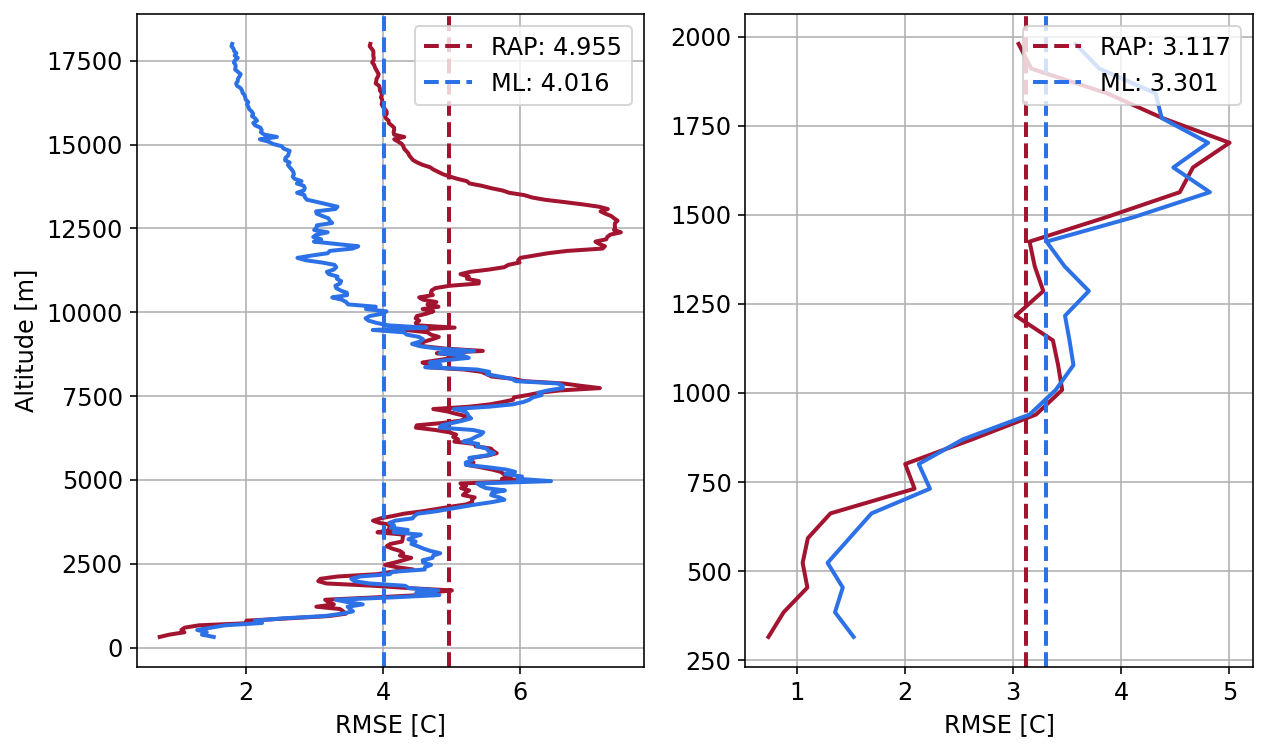

In [255]:
plot_altitude_rmse_verticle(nnet, {'im': IMtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,TEMPERATURE], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

# RAP + RTMA

### Temperature

In [256]:
RAPtrain, RAOBtrain, _, RTMAtrain, RAPtest, RAOBtest, _, RTMAtest = parition(rap=rap, raob=raob, rtma=rtma)

input_dims = [PRESSURE, TEMPERATURE]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, TEMPERATURE]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, TEMPERATURE]

RAPtrain.shape, RAOBtrain.shape, RTMAtrain.shape, RAPtest.shape, RAOBtest.shape, RTMAtest.shape

((587, 256, 2),
 (587, 256),
 (587, 3, 3, 3),
 (147, 256, 2),
 (147, 256),
 (147, 3, 3, 3))

In [257]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

goes_hiddens_list = [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 4)]
n_units_in_conv_layers = [[nu] * nl for nu in [16, 32, 128] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(goes_hiddens_list, n_units_in_conv_layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for goes_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(RTMAtrain.shape[1:], RAPtrain.shape[1:],
                                    goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                    RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', seed=1234)
    nnet.train(RTMAtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
               verbose=False, learning_rate=0.001)

    Y = nnet.use({'im': RTMAtrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': RTMAtest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=81.0)

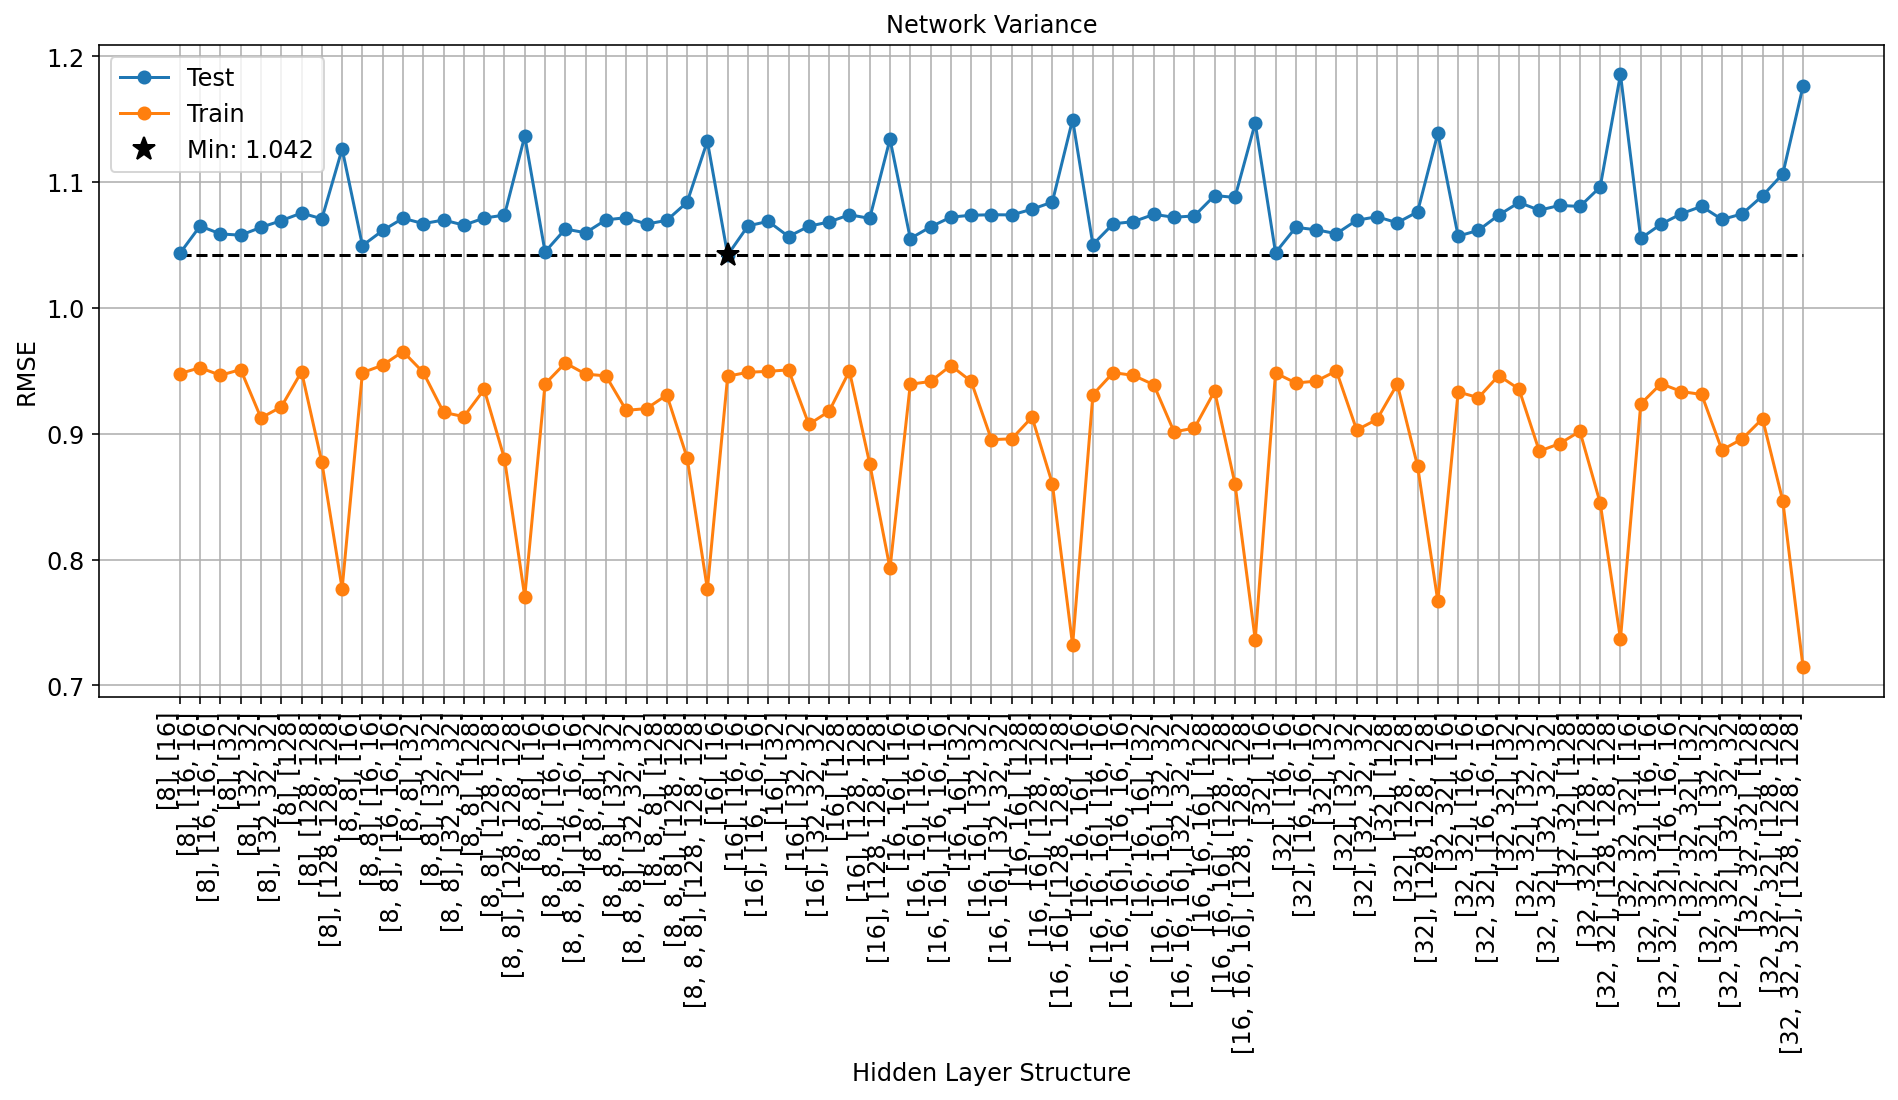

In [258]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

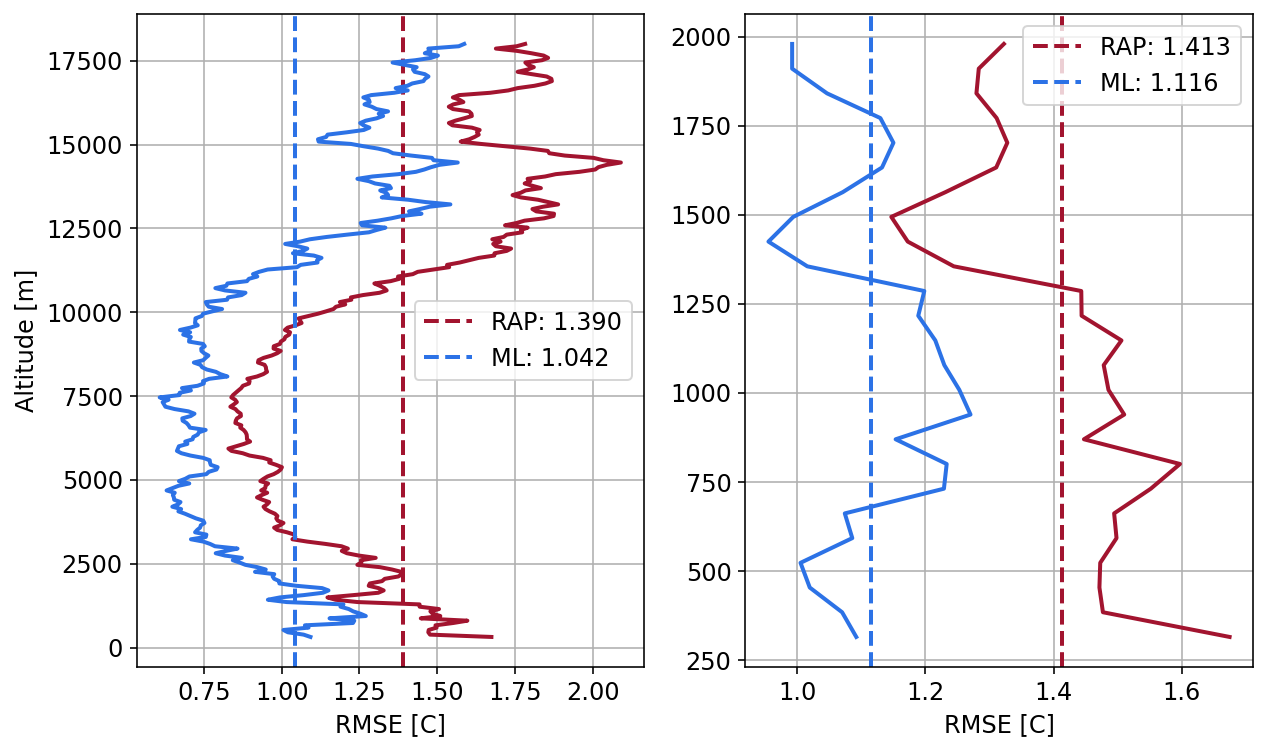

In [259]:
plot_altitude_rmse_verticle(best_nnet, {'im': RTMAtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

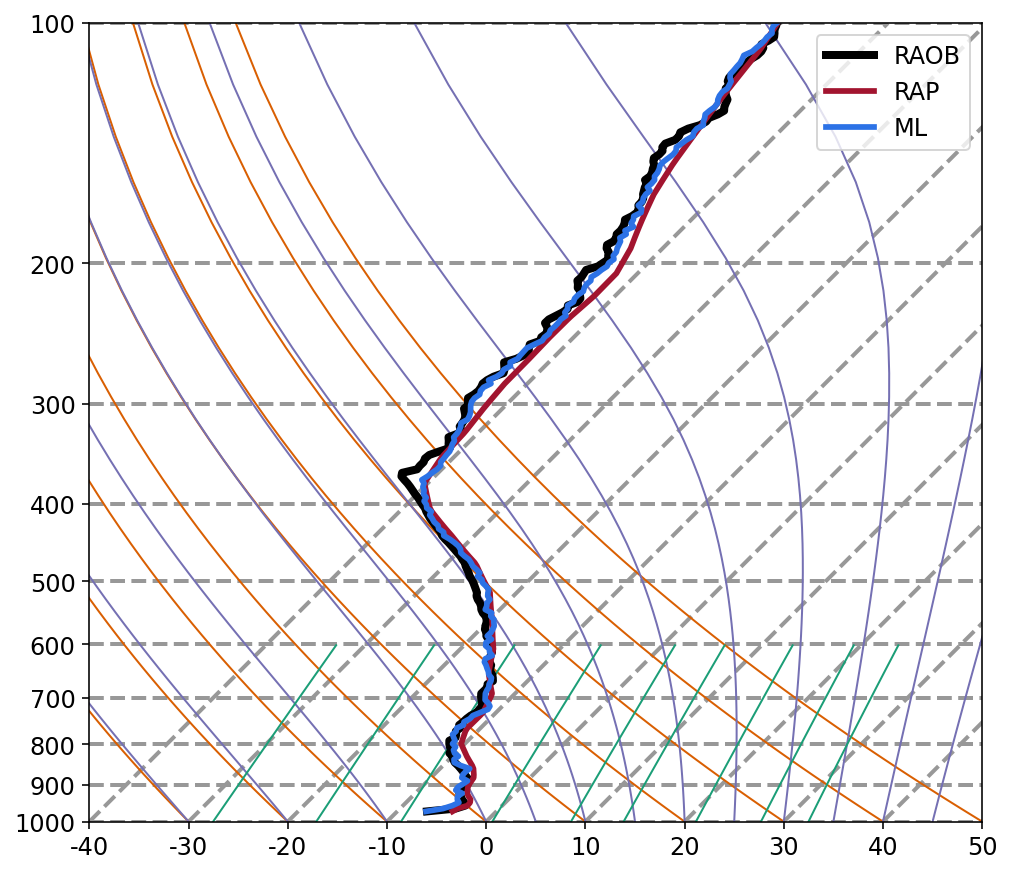

In [260]:
i = 17
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':RTMAtrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [261]:
interm = tf.keras.Model(best_nnet.model.inputs,best_nnet.model.get_layer('concatenate').output)
def iterm_predict(goes, rap):
    goes = best_nnet._standardizeIM(goes)
    rap  = best_nnet._standardizeRAP(rap)
    return interm.predict({'im': goes, 'rap': rap})

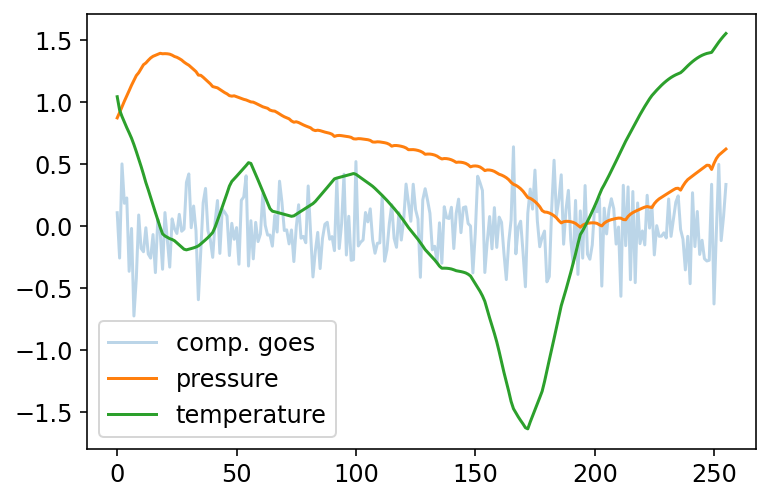

In [262]:
i = 2
Y = iterm_predict(RTMAtrain[i:i+1], RAPtrain[i:i+1])

plt.plot(Y[0,:,2], alpha=0.3, label='comp. goes')
plt.plot(Y[0,:,0], label='pressure')
plt.plot(Y[0,:,1], label='temperature')

plt.legend();

In [231]:
rtma_type_indicies = np.arange(len(rtma_type))
combinations = []
for length in rtma_type_indicies:
    combinations += list(itertools.combinations(rtma_type_indicies, length+1))

In [200]:
all_trials = []

for c in combinations:

    IMtrain = RTMAtrain[:,:,:, c]
    IMtest = RTMAtest[:,:,:, c]

    trial = []

    for t in range(10):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [16], [16], [(10, 1)], 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
                   verbose=False, learning_rate=0.001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

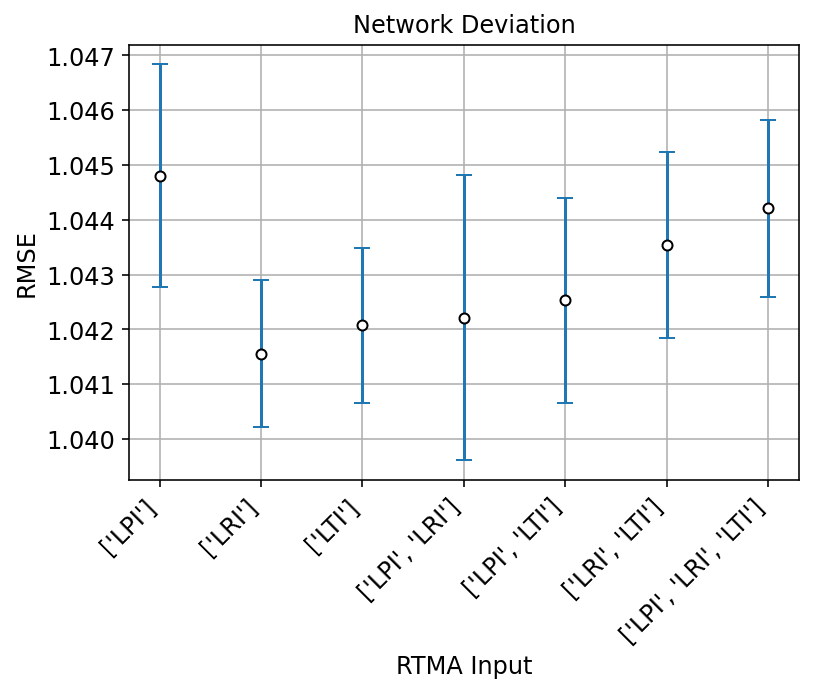

In [201]:
labels = [rtma_type[list(c)].tolist() for c in combinations]

fig, ax = plt.subplots(1, figsize=(6, 4))

ax.errorbar(np.arange(len(combinations)), all_trials.mean(axis=1), yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('RTMA Input'); ax.set_ylabel('RMSE');

In [202]:
rtma_type

array(['LPI', 'LRI', 'LTI'], dtype='<U3')

In [203]:
IMtrain = RTMAtrain[:,:,:, (1,)]
IMtest = RTMAtest[:,:,:, (1,)]

nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                             [16], [16], [(10, 1)], 
                             RAOBtrain.shape[1], im_activation='tanh',
                             rap_activation='tanh')

nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
           verbose=False, learning_rate=0.001)

MultiNeuralNetwork(256)
  Final objective value is 0.04945 in 3.0614 seconds.

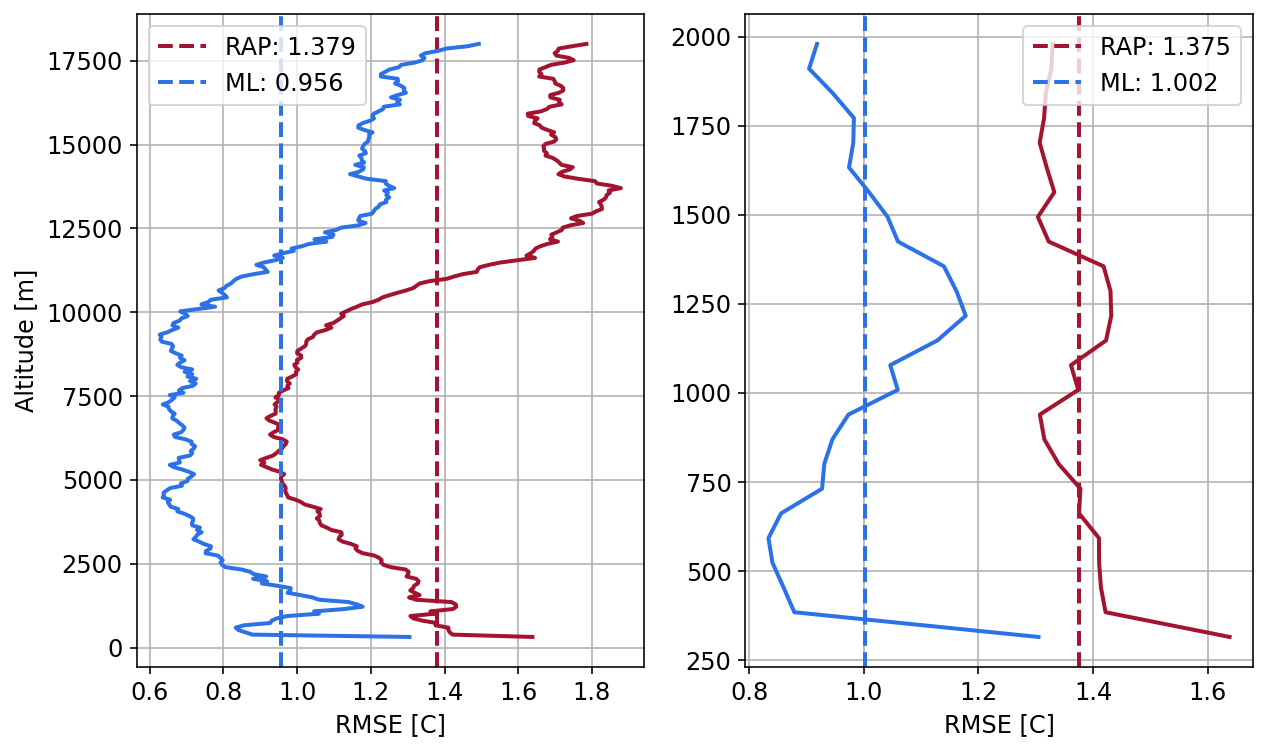

In [204]:
plot_altitude_rmse_verticle(nnet, {'im': IMtrain, 'rap': RAPtrain}, RAOBtrain, RAPtrain[:,:,TEMPERATURE], alt=raob[0, :, -1])  

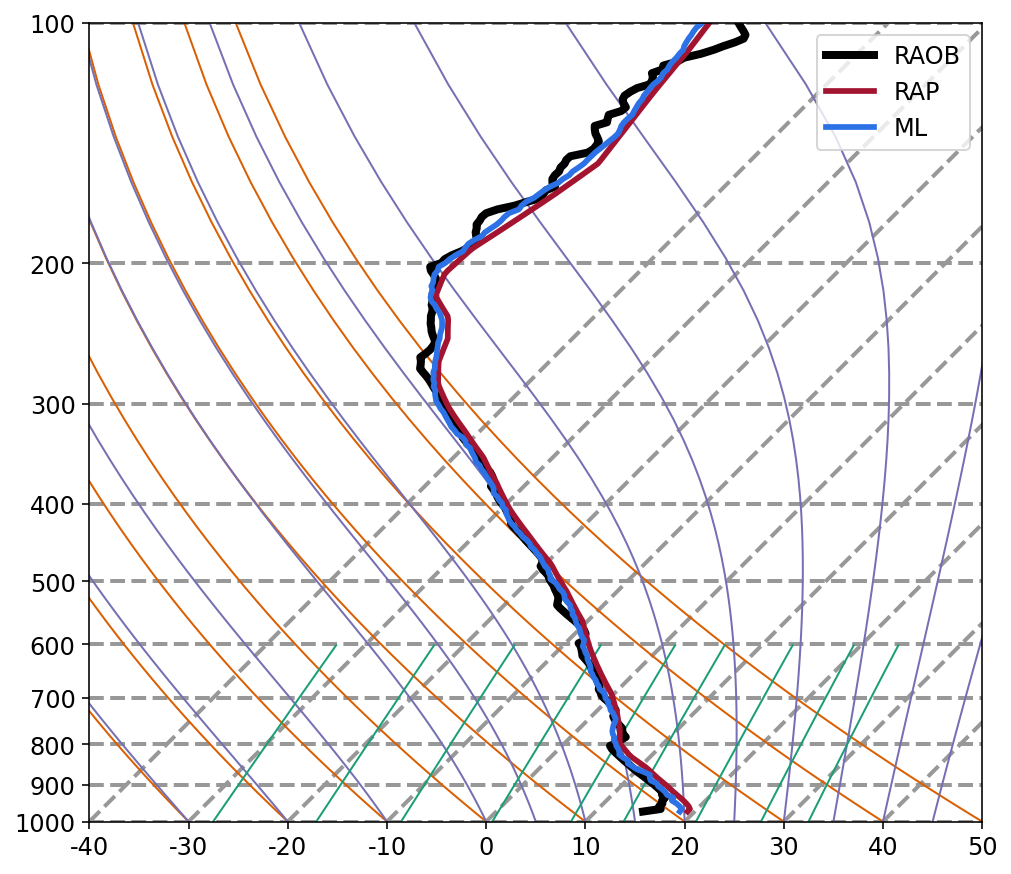

In [205]:
i = 14
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use({'im':IMtest[i:i+1],'rap':RAPtest[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [207]:
RAPtrain, RAOBtrain, _, RTMAtrain, RAPtest, RAOBtest, _, RTMAtest = parition(rap=rap, raob=raob, rtma=rtma)

input_dims = [PRESSURE, DEWPOINT]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, DEWPOINT]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, DEWPOINT]

RAPtrain.shape, RAOBtrain.shape, RTMAtrain.shape, RAPtest.shape, RAOBtest.shape, RTMAtest.shape

((587, 256, 2),
 (587, 256),
 (587, 3, 3, 3),
 (147, 256, 2),
 (147, 256),
 (147, 3, 3, 3))

In [208]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

goes_hiddens_list = [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 4)]
n_units_in_conv_layers = [[nu] * nl for nu in [16, 32, 128] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(goes_hiddens_list, n_units_in_conv_layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for goes_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(RTMAtrain.shape[1:], RAPtrain.shape[1:],
                                    goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                    RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', seed=1234)
    nnet.train(RTMAtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
               verbose=False, learning_rate=0.001)

    Y = nnet.use({'im': RTMAtrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': RTMAtest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=81.0)

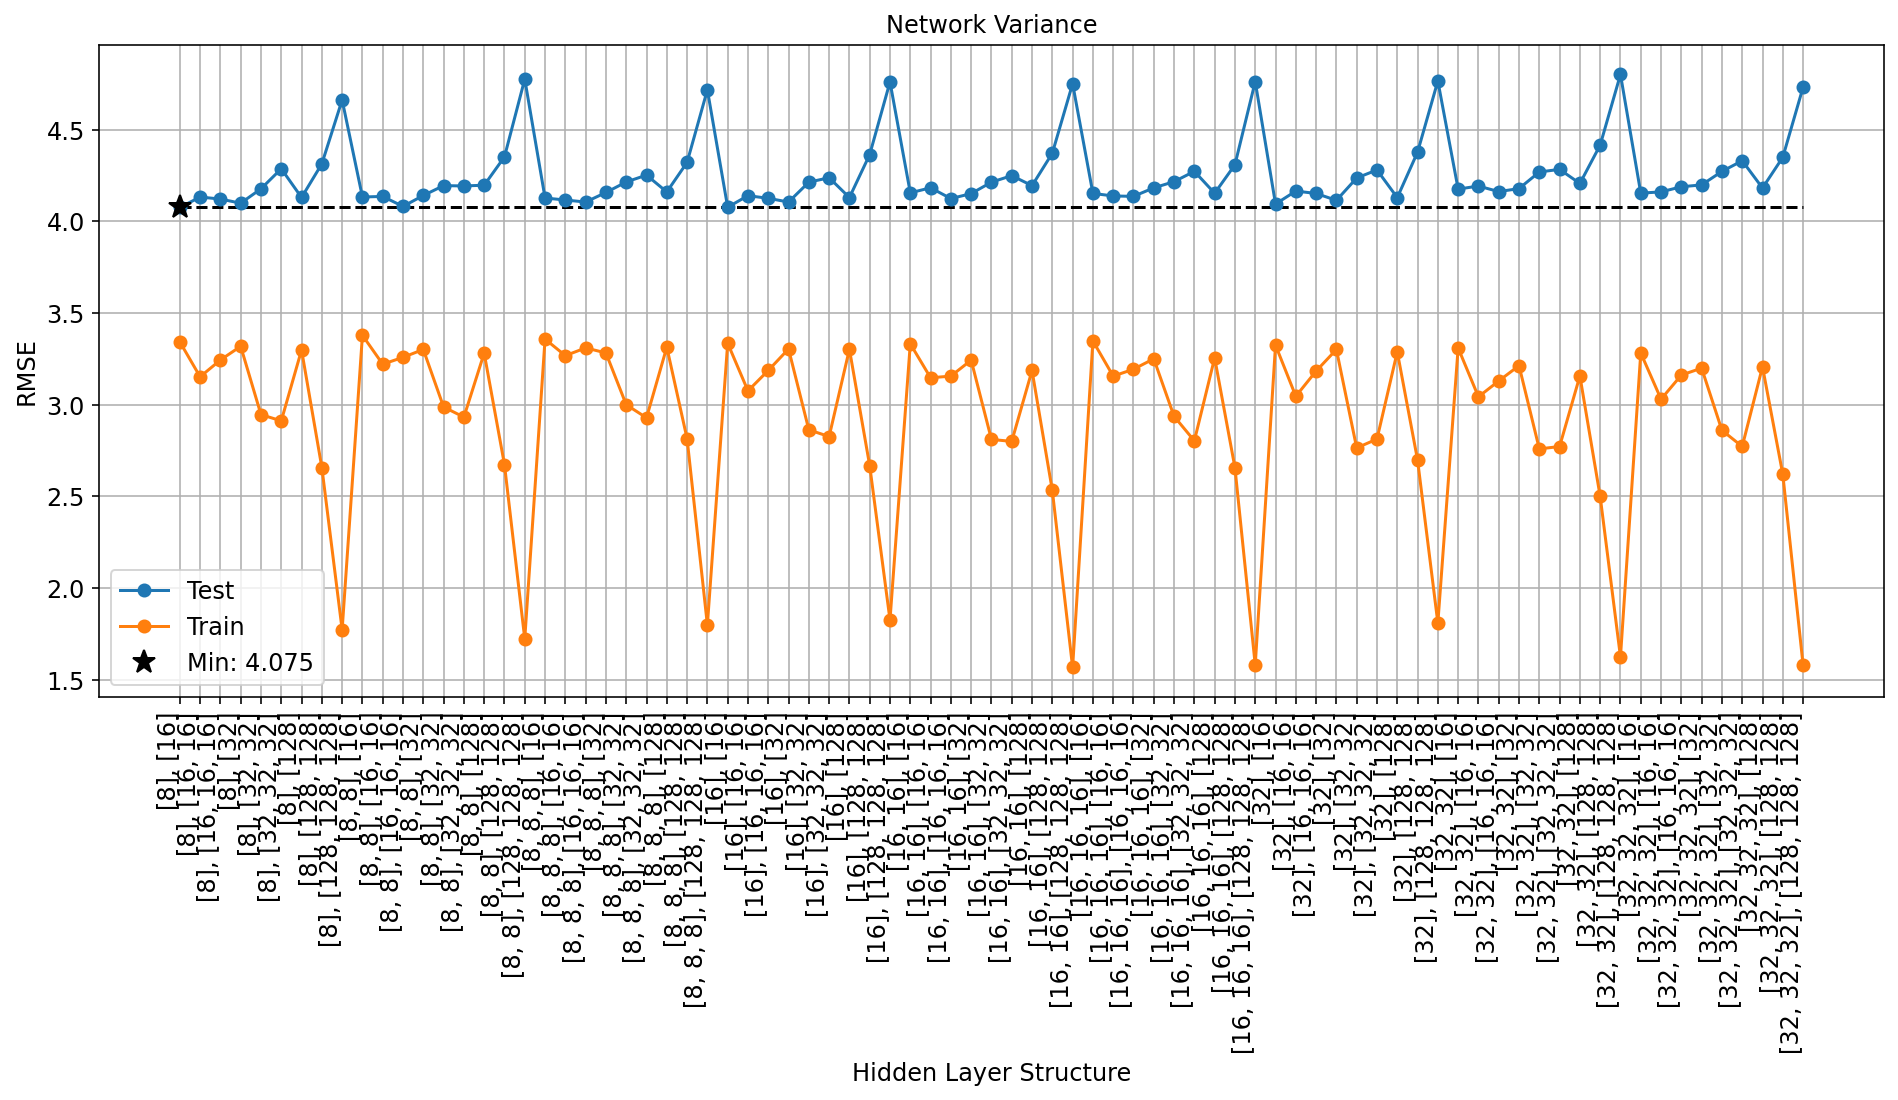

In [209]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

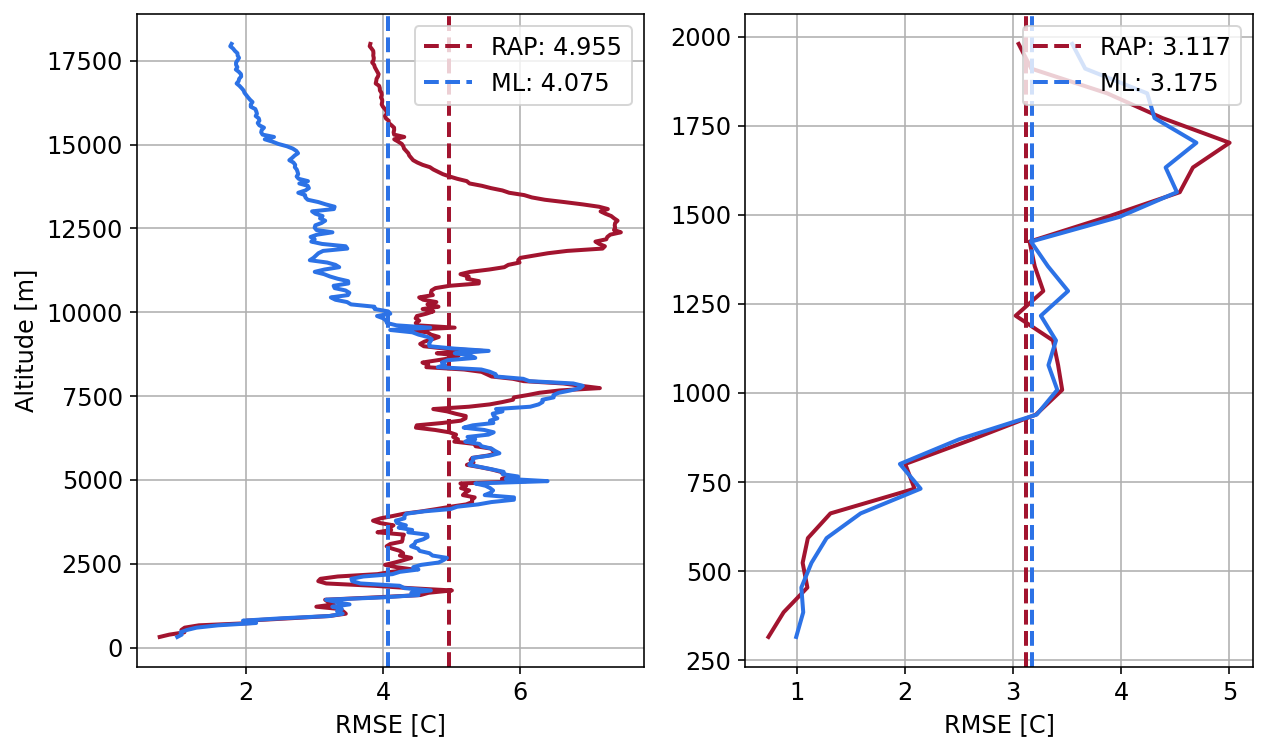

In [210]:
plot_altitude_rmse_verticle(best_nnet, {'im': RTMAtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

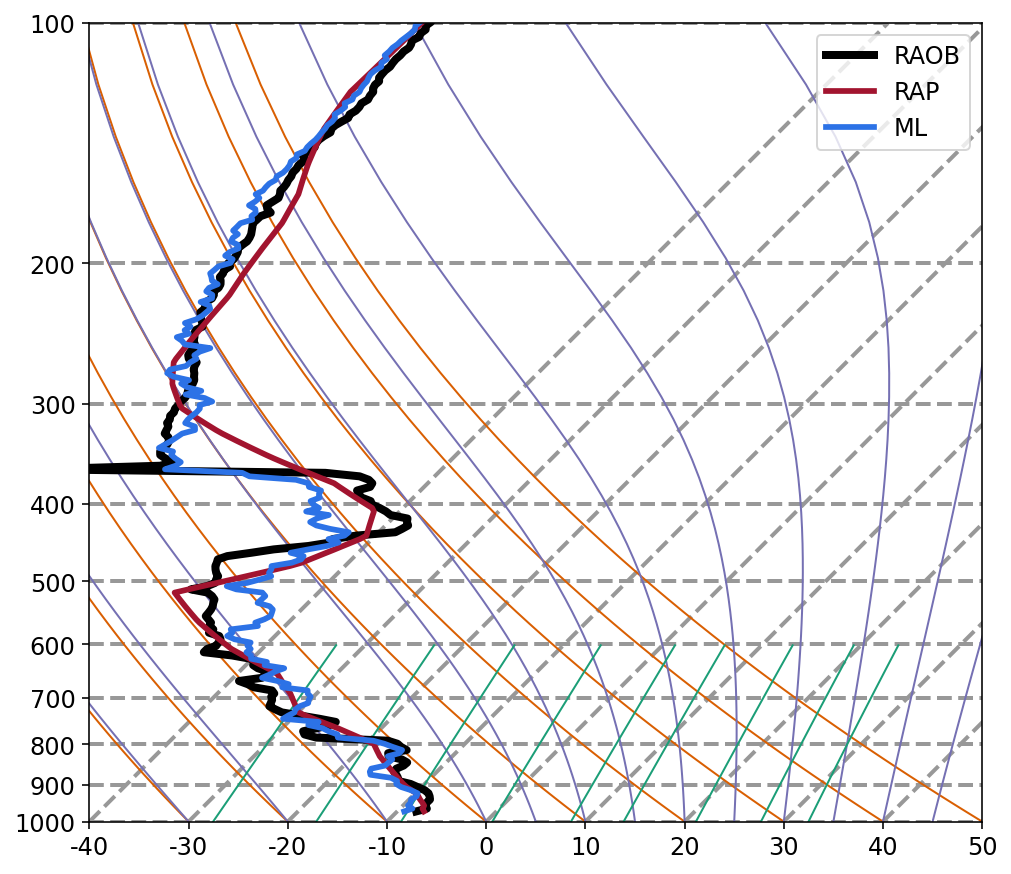

In [213]:
i = 17
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':RTMAtrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [232]:
interm = tf.keras.Model(best_nnet.model.inputs,best_nnet.model.get_layer('concatenate').output)
def iterm_predict(goes, rap):
    goes = best_nnet._standardizeIM(goes)
    rap  = best_nnet._standardizeRAP(rap)
    return interm.predict({'im': goes, 'rap': rap})

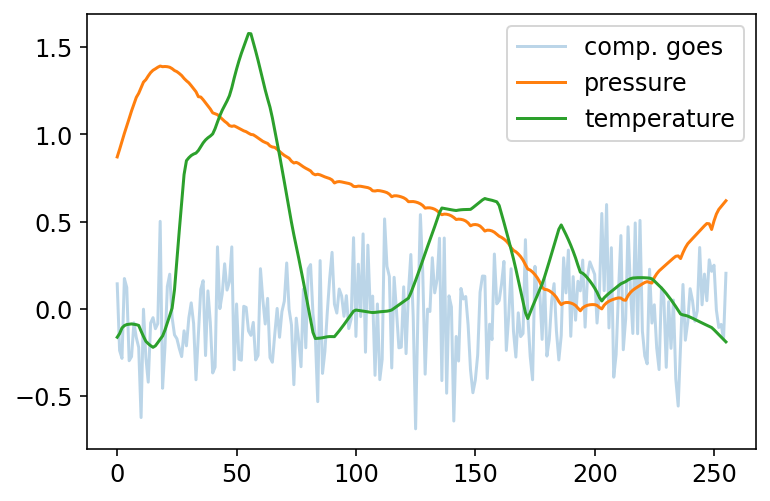

In [233]:
i = 2
Y = iterm_predict(RTMAtrain[i:i+1], RAPtrain[i:i+1])

plt.plot(Y[0,:,2], alpha=0.3, label='comp. goes')
plt.plot(Y[0,:,0], label='pressure')
plt.plot(Y[0,:,1], label='temperature')

plt.legend();

In [216]:
rtma_type_indicies = np.arange(len(rtma_type))
combinations = []
for length in rtma_type_indicies:
    combinations += list(itertools.combinations(rtma_type_indicies, length+1))

In [219]:
all_trials = []

for c in combinations:

    IMtrain = RTMAtrain[:,:,:, c]
    IMtest = RTMAtest[:,:,:, c]

    trial = []

    for t in range(10):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [8], [16], [(10, 1)], 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
                   verbose=False, learning_rate=0.001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

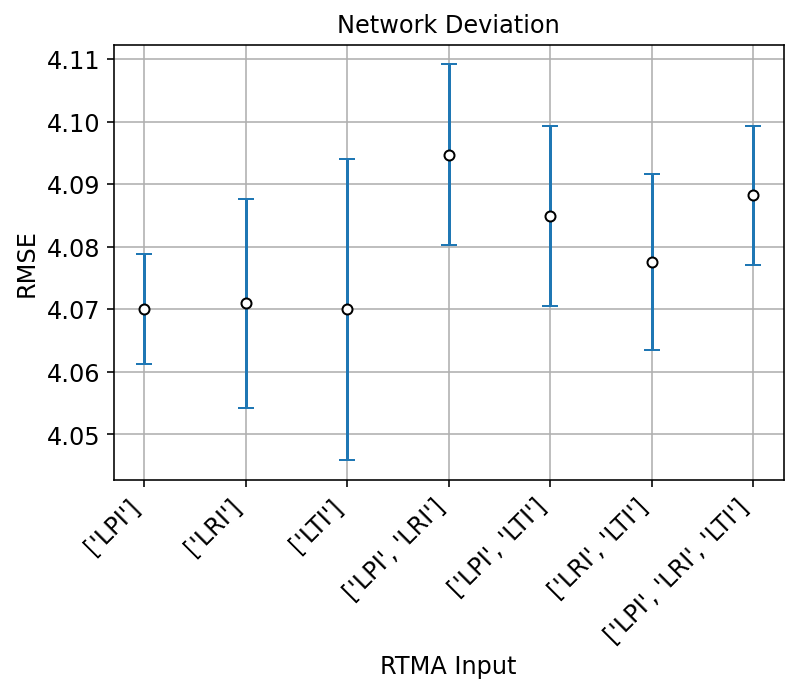

In [220]:
labels = [rtma_type[list(c)].tolist() for c in combinations]

fig, ax = plt.subplots(1, figsize=(6, 4))

ax.errorbar(np.arange(len(combinations)), all_trials.mean(axis=1), yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('RTMA Input'); ax.set_ylabel('RMSE');

In [221]:
rtma_type

array(['LPI', 'LRI', 'LTI'], dtype='<U3')

In [222]:
IMtrain = RTMAtrain[:,:,:, (0,)]
IMtest = RTMAtest[:,:,:, (0,)]

nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                             [16], [16], [(10, 1)], 
                             RAOBtrain.shape[1], im_activation='tanh',
                             rap_activation='tanh')

nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
           verbose=False, learning_rate=0.001)

MultiNeuralNetwork(256)
  Final objective value is 0.27589 in 2.4585 seconds.

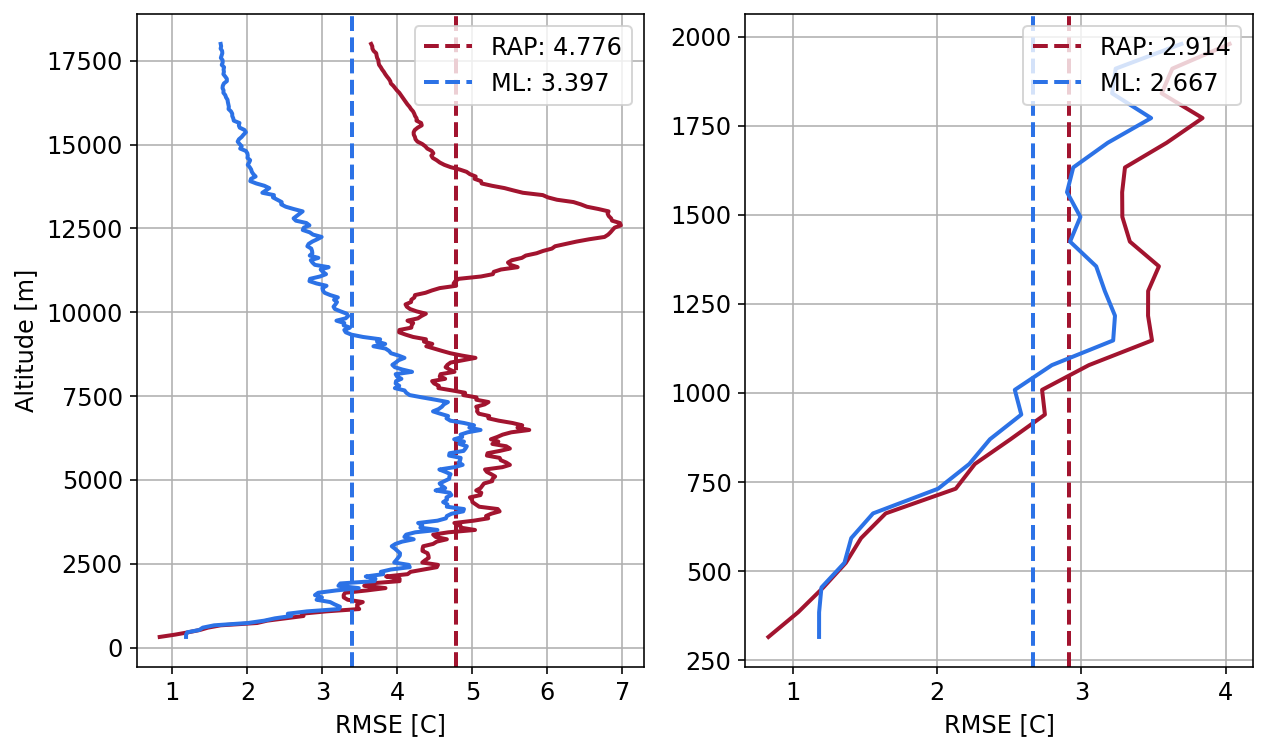

In [223]:
plot_altitude_rmse_verticle(nnet, {'im': IMtrain, 'rap': RAPtrain}, RAOBtrain, RAPtrain[:,:,TEMPERATURE], alt=raob[0, :, -1])  

# RAP + GOES + RTMA